# Overview


In this project, I attempted to create a prediction model for soccer match outcomes using various approaches. I aggregated team-specific features, assessed VIF (Variance Inflation Factor), and checked feature correlations at each stage before finalizing the feature selection. Additionally, I performed some basic feature engineering by combining existing features in straightforward ways.

Despite my efforts to address multicollinearity, the predictive power of the model I developed was not satisfactory. I must acknowledge that I failed to incorporate all available data, particularly the XML data related to match details. I believe that valuable predictive insights may have been overlooked in this unutilized dataset.

I constructed logistic and random forest models to forecast game outcomes, although their accuracy varied.

I conducted a thorough analysis of missing values, examined feature distributions, and visualized certain aspects of the data. I also performed statistical tests to evaluate means and investigate any potential home team advantage.

However, I am dissatisfied with the extent of analysis performed and the quality of the models developed. It appears that I may have identified some critical features that were not integrated into the model.

Overall, this modeling task proved to be quite comprehensive and challenging. I was uncertain about the best approach to tackle it, and I remain uncertain whether there is a definitive solution given the numerous possible directions this analysis could take.

Structure of this project goes as:

- Analyzing each sub dataset, doing EDA, feature analysis and feature engeneering.
    - Aggregation of specific dataframes and features. 
    - Merging of dataframes based on desired features. Doing VIF, and correlation analysis and building a model. 

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
import warnings
from scipy import stats
from scipy.stats import ttest_rel
from collections import defaultdict
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
sns.set_palette("RdBu_r")
%load_ext nb_black

warnings.filterwarnings("ignore", category=FutureWarning)


<IPython.core.display.Javascript object>

In [2]:
# Connection to sqlite database
conn = sqlite3.connect("./database.sqlite")

# Loading data into appropriate data frames
country = pd.read_sql_query("SELECT * FROM Country", conn)
league = pd.read_sql_query("SELECT * FROM League", conn)
match = pd.read_sql_query("SELECT * FROM Match", conn)
player = pd.read_sql_query("SELECT * FROM Player", conn)
player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
team = pd.read_sql_query("SELECT * FROM Team", conn)
team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)
sqlite_sequence = pd.read_sql_query("SELECT * FROM sqlite_sequence", conn)

<IPython.core.display.Javascript object>

# Data

## Country Data

In [3]:
country.shape

(11, 2)

<IPython.core.display.Javascript object>

In [4]:
country

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


<IPython.core.display.Javascript object>

----
- 11 countries in the dataset
- Only European countries in this list
---

## League Data

In [5]:
league.shape

(11, 3)

<IPython.core.display.Javascript object>

In [6]:
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


<IPython.core.display.Javascript object>

- Leagues corresponding to countries

## Match Data

In [7]:
# Match data
match.shape

(25979, 115)

<IPython.core.display.Javascript object>

In [8]:
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


<IPython.core.display.Javascript object>

#### Looking at columns

In [9]:
match.columns.values

array(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_X1',
       'home_player_X2', 'home_player_X3', 'home_player_X4',
       'home_player_X5', 'home_player_X6', 'home_player_X7',
       'home_player_X8', 'home_player_X9', 'home_player_X10',
       'home_player_X11', 'away_player_X1', 'away_player_X2',
       'away_player_X3', 'away_player_X4', 'away_player_X5',
       'away_player_X6', 'away_player_X7', 'away_player_X8',
       'away_player_X9', 'away_player_X10', 'away_player_X11',
       'home_player_Y1', 'home_player_Y2', 'home_player_Y3',
       'home_player_Y4', 'home_player_Y5', 'home_player_Y6',
       'home_player_Y7', 'home_player_Y8', 'home_player_Y9',
       'home_player_Y10', 'home_player_Y11', 'away_player_Y1',
       'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
       'away_player_Y5', 'away_player_Y6', 'away_player_Y7',
       'aw

<IPython.core.display.Javascript object>

- We can see that columns consist of id's
- After that we have match attributes: season, stage, date, number of goals
- This is follwed by players coordinates on home and away team
- After this we have specifics on players in each team
- After that we have match statistics
- Finally ending with columns about betting odds for matches from differnd betting organisations.

#### Looking at datatypes

In [10]:
match.dtypes.value_counts()

float64    96
object     10
int64       9
dtype: int64

<IPython.core.display.Javascript object>

In [11]:
match.select_dtypes(include="int64").head()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal
0,1,1,1,1,492473,9987,9993,1,1
1,2,1,1,1,492474,10000,9994,0,0
2,3,1,1,1,492475,9984,8635,0,3
3,4,1,1,1,492476,9991,9998,5,0
4,5,1,1,1,492477,7947,9985,1,3


<IPython.core.display.Javascript object>

In [12]:
match.select_dtypes(include="O").head()

,season,date,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,2008/2009,2008-08-17 00:00:00,None,None,None,None,None,None,None,None
1,2008/2009,2008-08-16 00:00:00,None,None,None,None,None,None,None,None
2,2008/2009,2008-08-16 00:00:00,None,None,None,None,None,None,None,None
3,2008/2009,2008-08-17 00:00:00,None,None,None,None,None,None,None,None
4,2008/2009,2008-08-16 00:00:00,None,None,None,None,None,None,None,None


<IPython.core.display.Javascript object>

- We can see object data for the game events/statistics part

In [13]:
# Turning date into datetime
match["date"] = pd.to_datetime(match["date"])

<IPython.core.display.Javascript object>

In [14]:
# Checking these 'None' values: Turns out they are XML
match[["goal", "shoton", "foulcommit"]].value_counts().head(5)

goal                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

<IPython.core.display.Javascript object>

---
- We can see XML data in the goal column, this XML is shown as None expression. All of the statistics match columns are in this form. 
- Data needs to be extracted from here. Dictionary form would probably the best option. 
---

In [15]:
match.select_dtypes(include="float64").columns

Index(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4',
       'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8',
       'home_player_X9', 'home_player_X10', 'home_player_X11',
       'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4',
       'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8',
       'away_player_X9', 'away_player_X10', 'away_player_X11',
       'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4',
       'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8',
       'home_player_Y9', 'home_player_Y10', 'home_player_Y11',
       'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
       'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8',
       'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1',
       'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5',
       'home_player_6', 

<IPython.core.display.Javascript object>

- Coordinates, player identifications, and betting odds are in float form
- Coordinates are in float form due to some missing values in columns, turning them to integer didnt work. 

### Duplicate values

In [16]:
duplicates = match.apply(lambda col: col.duplicated().sum())

<IPython.core.display.Javascript object>

In [17]:
# Can check with different tail or head values
duplicates.head(20)

id                      0
country_id          25968
league_id           25968
season              25971
stage               25941
date                24285
match_api_id            0
home_team_api_id    25680
away_team_api_id    25680
home_team_goal      25968
away_team_goal      25969
home_player_X1      25975
home_player_X2      25969
home_player_X3      25970
home_player_X4      25971
home_player_X5      25969
home_player_X6      25969
home_player_X7      25969
home_player_X8      25969
home_player_X9      25969
dtype: int64

<IPython.core.display.Javascript object>

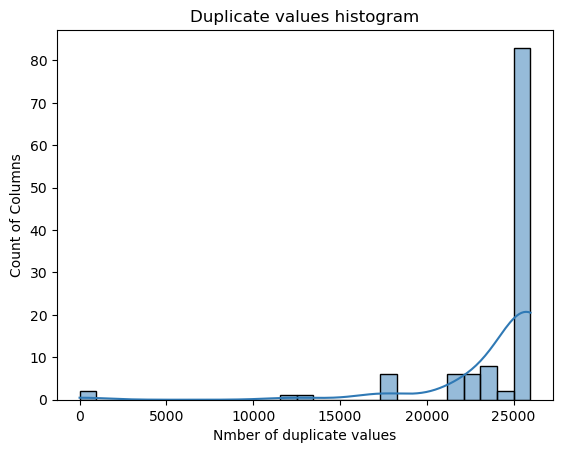

<IPython.core.display.Javascript object>

In [18]:
# Visualizing duplicates
sns.histplot(duplicates, kde=True)
plt.title("Duplicate values histogram")
plt.xlabel("Nmber of duplicate values")
plt.ylabel("Count of Columns")
plt.show()

- Duplicate values are not an issue here. Columns with duplicates, like coordinates, player IDs, and goal counts, are naturally repetitive. Betting odds have limited precision, and match statistics might show 'None' due to XML formatting. However, unique identifiers like Match ID or ID should never be duplicated, and they aren't in this dataset.

### Missing values

In [19]:
missing_values_count = match.isnull().sum()

<IPython.core.display.Javascript object>

In [20]:
missing_values_count

id                0
country_id        0
league_id         0
season            0
stage             0
              ...  
GBD           11817
GBA           11817
BSH           11818
BSD           11818
BSA           11818
Length: 115, dtype: int64

<IPython.core.display.Javascript object>

In [21]:
# Taking a look at columns with no missing values
missing_values_count[missing_values_count == 0]

id                  0
country_id          0
league_id           0
season              0
stage               0
date                0
match_api_id        0
home_team_api_id    0
away_team_api_id    0
home_team_goal      0
away_team_goal      0
dtype: int64

<IPython.core.display.Javascript object>

- Crucial items, ID's and goals don't have any missing values.

In [22]:
# Taking a look at number of missing values per column
match.isnull().sum().values

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,  1821,  1821,  1832,  1832,  1832,  1832,  1832,
        1832,  1832,  1832,  1832,  1832,  1832,  1832,  1832,  1832,
        1832,  1832,  1832,  1833,  1833,  1839,  1821,  1821,  1832,
        1832,  1832,  1832,  1832,  1832,  1832,  1832,  1832,  1832,
        1832,  1832,  1832,  1832,  1832,  1832,  1832,  1833,  1833,
        1839,  1224,  1315,  1281,  1323,  1316,  1325,  1227,  1309,
        1273,  1436,  1555,  1234,  1278,  1293,  1321,  1335,  1313,
        1235,  1341,  1328,  1441,  1554, 11762, 11762, 11762, 11762,
       11762, 11762, 11762, 11762,  3387,  3387,  3387,  3404,  3404,
        3404,  3459,  3459,  3459,  3423,  3423,  3423, 14811, 14811,
       14811,  3408,  3408,  3408,  8882,  8882,  8882,  3411,  3411,
        3411, 11817, 11817, 11817, 11818, 11818, 11818])

<IPython.core.display.Javascript object>

---
- No missing data in first 11 columns
- We can see that there are few groupings of missing data
---

In [23]:
# First group of missing values
match.isnull().sum().values[11:77]

array([1821, 1821, 1832, 1832, 1832, 1832, 1832, 1832, 1832, 1832, 1832,
       1832, 1832, 1832, 1832, 1832, 1832, 1832, 1832, 1833, 1833, 1839,
       1821, 1821, 1832, 1832, 1832, 1832, 1832, 1832, 1832, 1832, 1832,
       1832, 1832, 1832, 1832, 1832, 1832, 1832, 1832, 1833, 1833, 1839,
       1224, 1315, 1281, 1323, 1316, 1325, 1227, 1309, 1273, 1436, 1555,
       1234, 1278, 1293, 1321, 1335, 1313, 1235, 1341, 1328, 1441, 1554])

<IPython.core.display.Javascript object>

In [24]:
# First missing values grouping
missing_coordinates = missing_values_count.index[11:77]
missing_coordinates

Index(['home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4',
       'home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8',
       'home_player_X9', 'home_player_X10', 'home_player_X11',
       'away_player_X1', 'away_player_X2', 'away_player_X3', 'away_player_X4',
       'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8',
       'away_player_X9', 'away_player_X10', 'away_player_X11',
       'home_player_Y1', 'home_player_Y2', 'home_player_Y3', 'home_player_Y4',
       'home_player_Y5', 'home_player_Y6', 'home_player_Y7', 'home_player_Y8',
       'home_player_Y9', 'home_player_Y10', 'home_player_Y11',
       'away_player_Y1', 'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
       'away_player_Y5', 'away_player_Y6', 'away_player_Y7', 'away_player_Y8',
       'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'home_player_1',
       'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5',
       'home_player_6', 

<IPython.core.display.Javascript object>

- We can see that this group of missing values is coordinate information on players

In [25]:
# Second missing values group
match.isnull().sum().values[77:85]

array([11762, 11762, 11762, 11762, 11762, 11762, 11762, 11762])

<IPython.core.display.Javascript object>

In [26]:
missing_stats = missing_values_count.index[77:85]
missing_stats

Index(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner',
       'possession'],
      dtype='object')

<IPython.core.display.Javascript object>

---
- Missing values for match statistics and match dynamics
---

In [27]:
# Third group of missing values, missing betting values
missing_bets = missing_values_count.index[85:]
missing_bets

Index(['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA',
       'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH',
       'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD',
       'BSA'],
      dtype='object')

<IPython.core.display.Javascript object>

- This group of missing values is group of betting odds, these are acronyms for betting organisations. Acronym endings mean the following H-Home team win, A-Away team win, D-Draw. 

In [28]:
missing_values_count.values[85:]

array([ 3387,  3387,  3387,  3404,  3404,  3404,  3459,  3459,  3459,
        3423,  3423,  3423, 14811, 14811, 14811,  3408,  3408,  3408,
        8882,  8882,  8882,  3411,  3411,  3411, 11817, 11817, 11817,
       11818, 11818, 11818])

<IPython.core.display.Javascript object>

- This group of missing values has the highest numbers of values missing

In [29]:
match_na_dict = match.isnull().sum().to_dict()

<IPython.core.display.Javascript object>

### Match missing values summary: 
---

**1st** group of missing values arround 1500's correspond to missing coordinates of players

**2nd** group of missing data correspond to game statistics or gameplay dynamic

**3rd** group is rellated to the betting organizations bet values, odds


#### Potential issues:

---
    
   - Coordinates missing for potential analysis using coordinates or best positions for specific players in teams (analysis for team optimization)
---
   
   - Possibly important and descriptive features missing from the match statistics section. Could be loosing out on importand patterns. 
---   
  
  - Depending on analysis, maybe the missing values of placed bets of those specific organizations would matter. Given that their predictions provide any predictive benefit in the final analysis. 
  
---

   - With regards to deletion of the missing values here, focus has to be put on what kind of analysis is being done. For some parts, deleting 11000+ matches just because information on bets is missing, would make little sense. 
   
   ---
   
   - Possible benefit for splitting the match dataset into these three parts based on missing values. 
   

### Match - Feature analysis and engeneering

In [30]:
# Season start dates
match.groupby("season")["date"].min()

season
2008/2009   2008-07-18
2009/2010   2009-07-11
2010/2011   2010-07-17
2011/2012   2011-07-16
2012/2013   2012-07-13
2013/2014   2013-07-13
2014/2015   2014-07-18
2015/2016   2015-07-17
Name: date, dtype: datetime64[ns]

<IPython.core.display.Javascript object>

- Seasons start in mid July each year

In [31]:
# Creating new columns for game outcomes
# Conditions for home team outcome
home_conditions = [
    (match["home_team_goal"] > match["away_team_goal"]),  # Home team wins
    (match["home_team_goal"] < match["away_team_goal"]),  # Home team loses
]

home_choices = [1, -1]

# Assigning values to the 'home_team_outcome' using np.select()
match["home_team_outcome"] = np.select(home_conditions, home_choices, default=0)

# Conditions for away team outcome (opposite of home team conditions)
away_conditions = [
    (match["home_team_goal"] < match["away_team_goal"]),  # Away team wins
    (match["home_team_goal"] > match["away_team_goal"]),  # Away team loses
]
# Choices for away team outcome (opposite of home team choices)
away_choices = [1, -1]

# Assigning values to the 'using np.select()
match["away_team_outcome"] = np.select(away_conditions, away_choices, default=0)

<IPython.core.display.Javascript object>

In [32]:
# Checking it
match[["home_team_outcome", "away_team_outcome"]].head()

,home_team_outcome,away_team_outcome
0,0,0
1,0,0
2,-1,1
3,1,-1
4,-1,1


<IPython.core.display.Javascript object>

- New columns added for better clarity on who wins who looses, and if there was a draw
- 1 = Win, -1 = Loss, 0 = Draw for given team

In [33]:
# Taking a look at number of matches per season
matches_per_season = match.groupby("season")["match_api_id"].count()
matches_per_season

season
2008/2009    3326
2009/2010    3230
2010/2011    3260
2011/2012    3220
2012/2013    3260
2013/2014    3032
2014/2015    3325
2015/2016    3326
Name: match_api_id, dtype: int64

<IPython.core.display.Javascript object>

- We can see quite stable ammount of matches per season

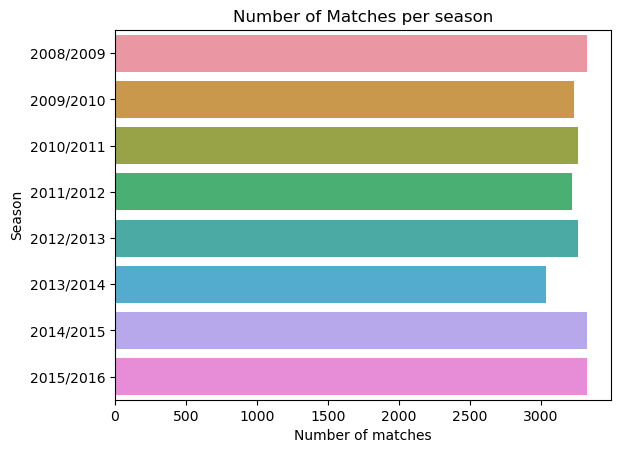

<IPython.core.display.Javascript object>

In [34]:
# Visualization of number of games per season
sns.barplot(y=matches_per_season.index, x=matches_per_season.values)
plt.title("Number of Matches per season")
plt.xlabel("Number of matches")
plt.ylabel("Season")
plt.show()

In [35]:
# Creating 'winner' column, to hold team_api_id of thw winner team, in case of a draw, this is 0.
condition_home_winner = match["home_team_outcome"] == 1
condition_away_winner = match["away_team_outcome"] == 1

match["winner"] = np.where(
    condition_home_winner,
    match["home_team_api_id"],
    np.where(condition_away_winner, match["away_team_api_id"], 0),
)

<IPython.core.display.Javascript object>

- New column that will hold the value of team api id of the winning team, in case of draw it is 0

###### Home advantage inspection

In [36]:
# Grouped by league_id and sum goals for home and away teams
home_away_per_league = (
    match.groupby("league_id")[["home_team_goal", "away_team_goal"]]
    .sum()
    .reset_index()
    .rename(columns={"league_id": "id"})
)

# Merged with the league DataFrame
home_away_per_league = home_away_per_league.merge(league, on="id")

# Calculated goal difference between home and away teams
home_away_per_league["h_a_goal_difference"] = (
    home_away_per_league["home_team_goal"] - home_away_per_league["away_team_goal"]
)

<IPython.core.display.Javascript object>

- I want to look more into possible home advantage some teams might experience

In [37]:
home_away_per_league

,id,home_team_goal,away_team_goal,country_id,name,h_a_goal_difference
0,1,2781,2060,1,Belgium Jupiler League,721
1,1729,4715,3525,1729,England Premier League,1190
2,4769,4265,3162,4769,France Ligue 1,1103
3,7809,3982,3121,7809,Germany 1. Bundesliga,861
4,10257,4528,3367,10257,Italy Serie A,1161
5,13274,4357,3185,13274,Netherlands Eredivisie,1172
6,15722,2678,1978,15722,Poland Ekstraklasa,700
7,17642,2890,2311,17642,Portugal Liga ZON Sagres,579
8,19694,2607,2197,19694,Scotland Premier League,410
9,21518,4959,3453,21518,Spain LIGA BBVA,1506


<IPython.core.display.Javascript object>

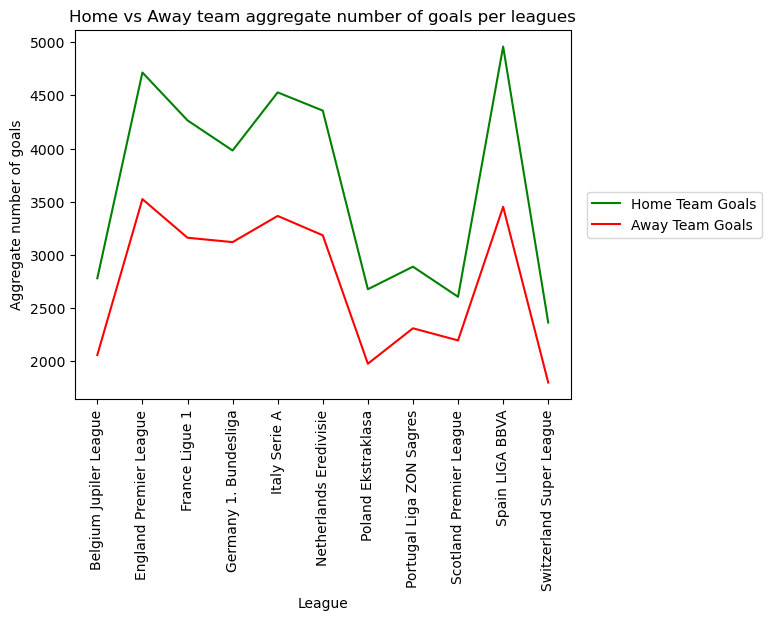

<IPython.core.display.Javascript object>

In [38]:
# Visualizing number of goals in total per league for home team and away team
sns.lineplot(
    data=home_away_per_league,
    y="home_team_goal",
    x="name",
    color="g",
    label="Home Team Goals",
)

sns.lineplot(
    data=home_away_per_league,
    y="away_team_goal",
    x="name",
    color="r",
    label="Away Team Goals",
)

plt.xticks(rotation=90)
plt.legend(loc="right", bbox_to_anchor=(1.4, 0.5))
plt.title("Home vs Away team aggregate number of goals per leagues")
plt.xlabel("League")
plt.ylabel("Aggregate number of goals")
plt.show()

- We can se clear systematic difference bewteen numbers of goals away and at home
- Home advantage indication for all leagues
- Differing level of the advantage between individual leagues

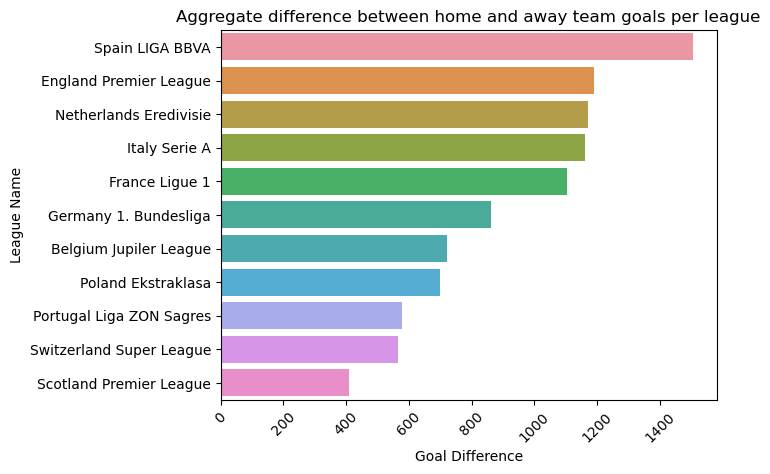

<IPython.core.display.Javascript object>

In [39]:
# Visualizing the difference between home and away teams aggregate goals
sns.barplot(
    data=home_away_per_league.sort_values(by="h_a_goal_difference", ascending=False),
    y="name",
    x="h_a_goal_difference",
)
plt.xticks(rotation=45)
plt.title("Aggregate difference between home and away team goals per league")
plt.xlabel("Goal Difference")
plt.ylabel("League Name")
plt.show()

- We can see the effect of home advantage in different leagues here. It seems that Spain has the highest home advantage, and Scotland has the lowest home advantage.
- This differences can be used as new feature: weights for leagues home advantage

In [40]:
# Creating weights for home advantage per league
sum_of_diff = home_away_per_league['h_a_goal_difference'].sum()

# Calculate home team advantage weights per league
home_away_per_league['weight'] = (
    home_away_per_league['h_a_goal_difference'] / sum_of_diff
).round(2)


<IPython.core.display.Javascript object>

In [41]:
home_away_per_league

,id,home_team_goal,away_team_goal,country_id,name,h_a_goal_difference,weight
0,1,2781,2060,1,Belgium Jupiler League,721,0.07
1,1729,4715,3525,1729,England Premier League,1190,0.12
2,4769,4265,3162,4769,France Ligue 1,1103,0.11
3,7809,3982,3121,7809,Germany 1. Bundesliga,861,0.09
4,10257,4528,3367,10257,Italy Serie A,1161,0.12
5,13274,4357,3185,13274,Netherlands Eredivisie,1172,0.12
6,15722,2678,1978,15722,Poland Ekstraklasa,700,0.07
7,17642,2890,2311,17642,Portugal Liga ZON Sagres,579,0.06
8,19694,2607,2197,19694,Scotland Premier League,410,0.04
9,21518,4959,3453,21518,Spain LIGA BBVA,1506,0.15


<IPython.core.display.Javascript object>

In [42]:
# Checking for number of leagues per country
number_of_leagues_per_coyuntry = match.groupby("country_id")["league_id"].nunique()

<IPython.core.display.Javascript object>

In [43]:
number_of_leagues_per_coyuntry

country_id
1        1
1729     1
4769     1
7809     1
10257    1
13274    1
15722    1
17642    1
19694    1
21518    1
24558    1
Name: league_id, dtype: int64

<IPython.core.display.Javascript object>

- One league per country. League and Country equivalent. 

##### Goal difference between home and away team

In [44]:
# Goal difference columns
match["goal_difference"] = match["home_team_goal"] - match["away_team_goal"]

<IPython.core.display.Javascript object>

In [45]:
match["goal_difference"].describe()

count    25979.000000
mean         0.383656
std          1.782403
min         -9.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max         10.000000
Name: goal_difference, dtype: float64

<IPython.core.display.Javascript object>

- We can use this goal difference to indicate the strength of the win or loss.
- We can see that goal difference ranges from -9 to 10 goals. With at least 50% of matches having no difference. We can see mean being 0.38, indicating higher goals for home teams. 
- This is the home advantage it seems

- Calculating the CI for the systematic difference of home and away teams
- Confidence interval of home and away team goals
    - H0: The mean of home goals is less than or equal to the mean of away goals
    - H1: The mean of home goals is greater than the mean of away goals

###### Testing the home advantage with paired t-test

In [46]:
# Test
home_goals = match['home_team_goal']
away_goals = match['away_team_goal']

# Paired t-test
t_stat, p_value = ttest_rel(home_goals, away_goals)

# Divide the p-value for one-tailed test
one_tailed_p_value = p_value / 2

print(f"T-statistic: {t_stat}")
print(f"One-tailed P-value: {one_tailed_p_value}")
alpha = 0.05
if one_tailed_p_value < alpha and t_stat > 0:
    print("Reject the null hypothesis: The mean of home goals is significantly greater than the mean of away goals.")
else:
    print("Fail to reject the null hypothesis: The mean of home goals is not significantly greater than the mean of away goals.")


T-statistic: 34.693433428329804
One-tailed P-value: 3.7880129771512274e-258
Reject the null hypothesis: The mean of home goals is significantly greater than the mean of away goals.


<IPython.core.display.Javascript object>

- We can confirm that home advantage exists based on raw number of goals

###### Visualizations of goal differences

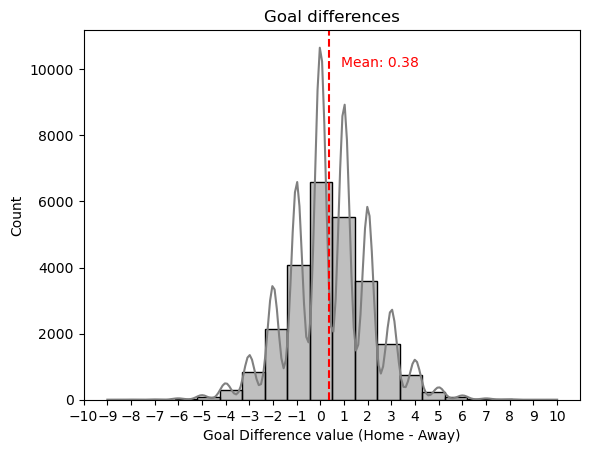

<IPython.core.display.Javascript object>

In [47]:
# Visualizing the distribution of goal differences
sns.histplot(match["goal_difference"], kde=True, bins=20, color="gray")
plt.title("Goal differences")
plt.xlabel("Goal Difference value (Home - Away)")
plt.xticks(range(-10, 11))
mean_diff = match["goal_difference"].mean()
plt.axvline(mean_diff, color="red", linestyle="--")
plt.text(
    mean_diff + 0.5,
    plt.gca().get_ylim()[1] * 0.9,
    f"Mean: {mean_diff:.2f}",
    color="red",
)
plt.show()

- We can see that goal difference of 4 and larger is quite rare
- Bellow, the probability of goald difference of 8 or more will be calculated

In [48]:
# Looking at probability of matches with difference of 8 or more
count_high_diff = ((match["goal_difference"]).abs() >= 8).sum()
total_matches = len(match)
probability = count_high_diff / total_matches
print(f"Probability of goal difference being 8 or higher: {probability:.4f}")
print(
    "This translates to odds of 1/1999, for every 1 game where the goal difference is 8 or higher, you would expect approximately 1999 games where the goal difference is less than 8."
)

Probability of goal difference being 8 or higher: 0.0005
This translates to odds of 1/1999, for every 1 game where the goal difference is 8 or higher, you would expect approximately 1999 games where the goal difference is less than 8.


<IPython.core.display.Javascript object>

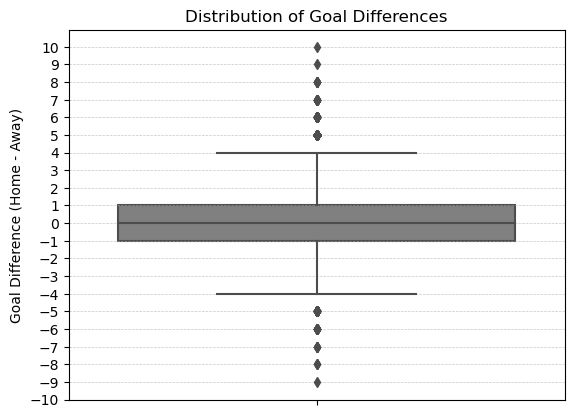

<IPython.core.display.Javascript object>

In [49]:
# Visualizing goal differences with boxplot
sns.boxplot(y=match["goal_difference"], color="grey")
plt.title("Distribution of Goal Differences")
plt.ylabel("Goal Difference (Home - Away)")
plt.yticks(range(-10, 11))
plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

- Can see some outliers in terms of goal differences, either wins or losses up to 10 points difference

###### Outlier game differences analysis

In [50]:
# How many outliers do we have? (1.5 IQR)
Q1 = match["goal_difference"].quantile(0.25)
Q3 = match["goal_difference"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

match_goal_diff_outliers = match[
    (match["goal_difference"] < lower_bound) | (match["goal_difference"] > upper_bound)
]
match_goal_diff_outliers.shape

(468, 119)

<IPython.core.display.Javascript object>

- Based on 1.5 IQR, we have 468 outliers

In [51]:
# Count outliers by league and reset index
outlier_goal_diff_per_league = (
    match_goal_diff_outliers.groupby("league_id")["goal_difference"]
    .count()
    .reset_index()
    .rename(columns={"goal_difference": "number_of_outliers", "league_id": "id"})
)

# Merge with the league DataFrame
outlier_goal_diff_per_league = outlier_goal_diff_per_league.merge(league, on="id")

<IPython.core.display.Javascript object>

Text(0, 0.5, 'League Name')

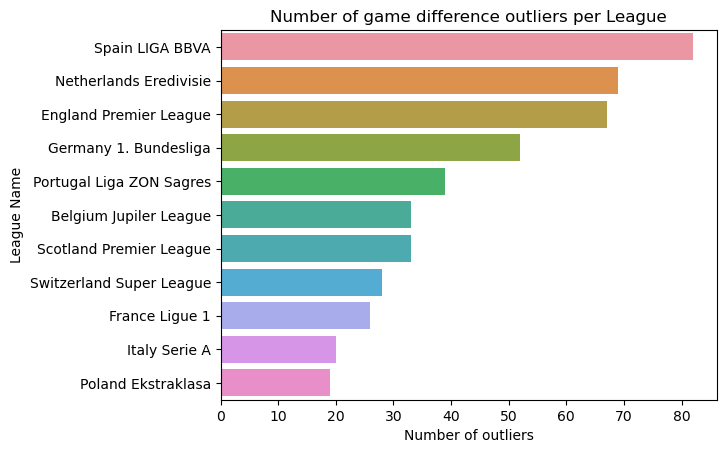

<IPython.core.display.Javascript object>

In [52]:
# Chart for number of outliers per league/country
sns.barplot(
    data=outlier_goal_diff_per_league.sort_values(
        by="number_of_outliers", ascending=False
    ),
    y="name",
    x="number_of_outliers",
)


plt.title("Number of game difference outliers per League")
plt.xlabel("Number of outliers")
plt.ylabel("League Name")

- We can see the number of outlier games per League, we see that the Spain is on the top.
- Suggestion for better indicator would be relative measure, dividing number of outlers with number of matches played. 

###### Number of wins and losses per month per year

In [53]:
# Create columns for wins and losses
# Assuming a win is when 'home_team_goal' > 'away_team_goal' and a loss is the opposite
match["won"] = (match["home_team_goal"] > match["away_team_goal"]).astype(int)
match["lost"] = (match["home_team_goal"] < match["away_team_goal"]).astype(int)

match["year"] = match["date"].dt.year
match["month"] = match["date"].dt.month

# Group by year and month and sum the wins and losses
games_per_month = match.groupby(["year", "month"])[["won", "lost"]].sum().reset_index()

# Create a new column 'year_month' for better visualization
games_per_month["year_month"] = (
    games_per_month["year"].astype(str)
    + "-"
    + games_per_month["month"].astype(str).str.zfill(2)
)

<IPython.core.display.Javascript object>

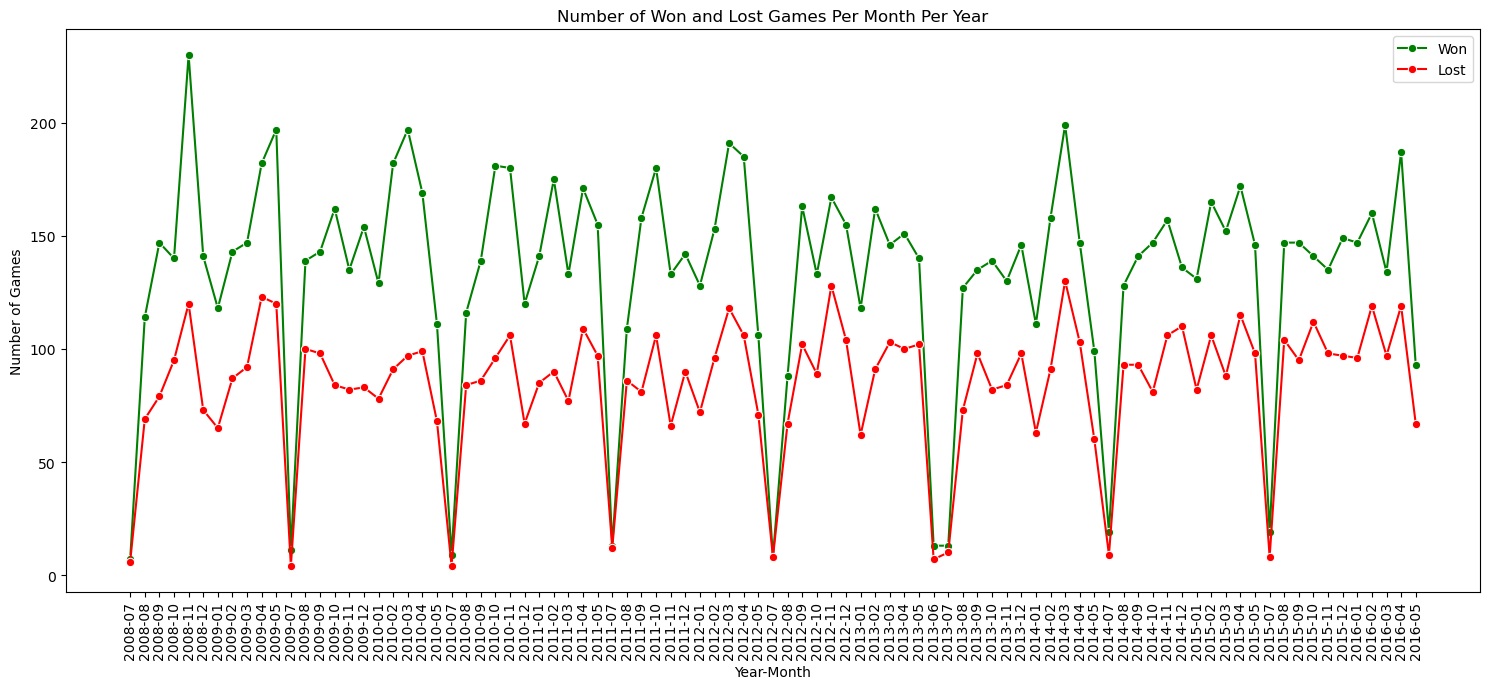

<IPython.core.display.Javascript object>

In [54]:
# Visualizing number of won and lost games per month per year
plt.figure(figsize=(15, 7))
sns.lineplot(
    data=games_per_month,
    x="year_month",
    y="won",
    marker="o",
    label="Won",
    color="green",
)
sns.lineplot(
    data=games_per_month,
    x="year_month",
    y="lost",
    marker="o",
    label="Lost",
    color="red",
)
plt.xticks(rotation=90)
plt.title("Number of Won and Lost Games Per Month Per Year")
plt.xlabel("Year-Month")
plt.ylabel("Number of Games")
plt.legend()
plt.tight_layout()
plt.show()

- We can see repeatng seasonality over the years, quite simmilar differences over the years between won and lost, but slightly narroing trend. Indicating less variable game outcomes.

##### Betting odds analysis

In [55]:
# Betting odds
betting_match = match[
    [
        "id",
        "country_id",
        "league_id",
        "season",
        "stage",
        "date",
        "match_api_id",
        "home_team_api_id",
        "away_team_api_id",
        "home_team_goal",
        "away_team_goal",
        "B365H",
        "B365D",
        "B365A",
        "BWH",
        "BWD",
        "BWA",
        "IWH",
        "IWD",
        "IWA",
        "LBH",
        "LBD",
        "LBA",
        "PSH",
        "PSD",
        "PSA",
        "WHH",
        "WHD",
        "WHA",
        "SJH",
        "SJD",
        "SJA",
        "VCH",
        "VCD",
        "VCA",
        "GBH",
        "GBD",
        "GBA",
        "BSH",
        "BSD",
        "BSA",
        "home_team_outcome",
        "away_team_outcome",
        "goal_difference",
    ]
].copy()

<IPython.core.display.Javascript object>

In [56]:
# Function to get the predicted outcome based on odds, lower odds indicate a higher probability
def get_predicted_outcome(row, home_odds, draw_odds, away_odds):
    min_odds = min(row[home_odds], row[draw_odds], row[away_odds])
    if min_odds == row[home_odds]:
        return "home_win"
    elif min_odds == row[draw_odds]:
        return "draw"
    else:
        return "away_win"


# List of betting organizations
betting_orgs = ["B365", "BW", "IW", "LB", "PS", "WH", "SJ", "VC", "GB", "BS"]

accuracy_dict = {}

for org in betting_orgs:
    # Get predicted outcomes
    betting_match[f"{org}_predicted"] = betting_match.apply(
        lambda row: get_predicted_outcome(row, f"{org}H", f"{org}D", f"{org}A"), axis=1
    )

    # Compare predicted outcomes with actual outcomes
    betting_match[f"{org}_correct"] = (
        (
            (betting_match["home_team_outcome"] == 1)
            & (betting_match[f"{org}_predicted"] == "home_win")
        )
        | (
            (betting_match["away_team_outcome"] == 1)
            & (betting_match[f"{org}_predicted"] == "away_win")
        )
        | (
            (betting_match["home_team_outcome"] == 0)
            & (betting_match["away_team_outcome"] == 0)
            & (betting_match[f"{org}_predicted"] == "draw")
        )
    )

    # Calculate accuracy
    accuracy = betting_match[f"{org}_correct"].mean()
    accuracy_dict[org] = accuracy

# Convert accuracy_dict to a dataframe for better visualization
accuracy_df = pd.DataFrame(
    list(accuracy_dict.items()), columns=["Betting Organization", "Accuracy"]
)

# Sort by accuracy
accuracy_df = accuracy_df.sort_values(by="Accuracy", ascending=False)

print(accuracy_df)

  Betting Organization  Accuracy
0                 B365  0.500751
7                   VC  0.499981
5                   WH  0.499095
1                   BW  0.499018
2                   IW  0.498826
3                   LB  0.498826
6                   SJ  0.451942
8                   GB  0.424805
9                   BS  0.424612
4                   PS  0.385273


<IPython.core.display.Javascript object>

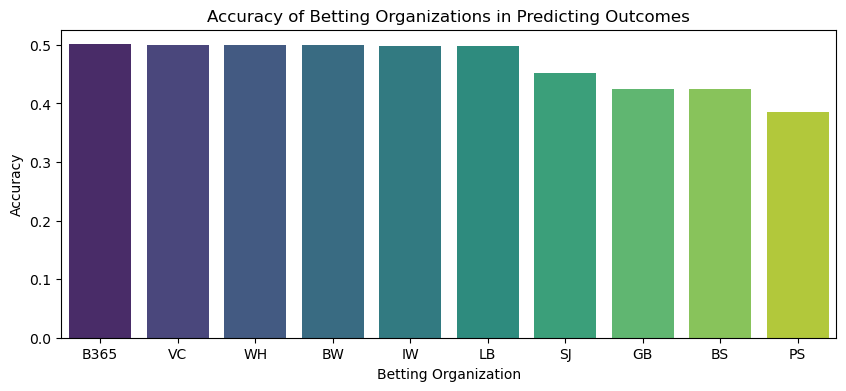

<IPython.core.display.Javascript object>

In [57]:
# Visualizng these accuracies
plt.figure(figsize=(10, 4))
sns.barplot(data=accuracy_df, x="Betting Organization", y="Accuracy", palette="viridis")
plt.title("Accuracy of Betting Organizations in Predicting Outcomes")
plt.ylabel("Accuracy")
plt.xlabel("Betting Organization")
plt.show()

- We can see that only B365 is barely if eve, more accurate than random chance of just 50%
- Questionable utility of these betting values

##### Looking at object data

In [58]:
match_object_cols = match.select_dtypes(include="O").columns.tolist()

<IPython.core.display.Javascript object>

In [59]:
match_obj_cols_events = match_object_cols[1:]

<IPython.core.display.Javascript object>

In [60]:
match_2 = match.drop(columns=match_obj_cols_events)

<IPython.core.display.Javascript object>

In [61]:
season_mapping = {
    "2008/2009": 1,
    "2009/2010": 2,
    "2010/2011": 3,
    "2011/2012": 4,
    "2012/2013": 5,
    "2013/2014": 6,
    "2014/2015": 7,
    "2015/2016": 8,
}

match_2["season"] = match_2["season"].map(season_mapping)

<IPython.core.display.Javascript object>

In [62]:
match_2.dtypes.value_counts()

float64           96
int64             18
datetime64[ns]     1
dtype: int64

<IPython.core.display.Javascript object>

##### Looking at missing values percentages of columns

In [63]:
missing_percentage = (match_2.isnull().sum() / len(match_2)) * 100

<IPython.core.display.Javascript object>

In [64]:
# Selecting columns with 30% and more of missing values
missing_percentage[missing_percentage > 30]

PSH    57.011432
PSD    57.011432
PSA    57.011432
SJH    34.189153
SJD    34.189153
SJA    34.189153
GBH    45.486739
GBD    45.486739
GBA    45.486739
BSH    45.490589
BSD    45.490589
BSA    45.490589
dtype: float64

<IPython.core.display.Javascript object>

In [65]:
# Columns to drop
columns_to_drop = ["GBH", "GBD", "GBA", "BSH", "BSD", "BSA", "SJH", "SJD", "SJA"]
match_2.drop(columns=columns_to_drop, inplace=True)

<IPython.core.display.Javascript object>

In [66]:
# Dictionary to see column and missing %
missing_percentage.to_dict()

{'id': 0.0,
 'country_id': 0.0,
 'league_id': 0.0,
 'season': 0.0,
 'stage': 0.0,
 'date': 0.0,
 'match_api_id': 0.0,
 'home_team_api_id': 0.0,
 'away_team_api_id': 0.0,
 'home_team_goal': 0.0,
 'away_team_goal': 0.0,
 'home_player_X1': 7.009507679279419,
 'home_player_X2': 7.009507679279419,
 'home_player_X3': 7.051849570807191,
 'home_player_X4': 7.051849570807191,
 'home_player_X5': 7.051849570807191,
 'home_player_X6': 7.051849570807191,
 'home_player_X7': 7.051849570807191,
 'home_player_X8': 7.051849570807191,
 'home_player_X9': 7.051849570807191,
 'home_player_X10': 7.051849570807191,
 'home_player_X11': 7.051849570807191,
 'away_player_X1': 7.051849570807191,
 'away_player_X2': 7.051849570807191,
 'away_player_X3': 7.051849570807191,
 'away_player_X4': 7.051849570807191,
 'away_player_X5': 7.051849570807191,
 'away_player_X6': 7.051849570807191,
 'away_player_X7': 7.051849570807191,
 'away_player_X8': 7.051849570807191,
 'away_player_X9': 7.055698833673352,
 'away_player_X10': 

<IPython.core.display.Javascript object>

- I've decided to remove the betting columns with missing values for more than 30% of the games, and all missing players coordinates and id's since imputing them doesnt seem like doable thing.
- Possibly player coordinates could be infered in some other way from data directly if I managed to group data cleverly to uncoover players positions. Another option would be to look at player coordinate history and impute based on most probable players position from previous games. 

In [67]:
# Columns to check for missing values and drop rows
columns_to_check = [
    "home_player_1",
    "home_player_2",
    "home_player_3",
    "home_player_4",
    "home_player_5",
    "home_player_6",
    "home_player_7",
    "home_player_8",
    "home_player_9",
    "home_player_10",
    "home_player_11",
    "away_player_1",
    "away_player_2",
    "away_player_3",
    "away_player_4",
    "away_player_5",
    "away_player_6",
    "away_player_7",
    "away_player_8",
    "away_player_9",
    "away_player_10",
    "away_player_11",
    "home_player_X1",
    "home_player_X2",
    "home_player_X3",
    "home_player_X4",
    "home_player_X5",
    "home_player_X6",
    "home_player_X7",
    "home_player_X8",
    "home_player_X9",
    "home_player_X10",
    "home_player_X11",
    "away_player_X1",
    "away_player_X2",
    "away_player_X3",
    "away_player_X4",
    "away_player_X5",
    "away_player_X6",
    "away_player_X7",
    "away_player_X8",
    "away_player_X9",
    "away_player_X10",
    "away_player_X11",
    "home_player_Y1",
    "home_player_Y2",
    "home_player_Y3",
    "home_player_Y4",
    "home_player_Y5",
    "home_player_Y6",
    "home_player_Y7",
    "home_player_Y8",
    "home_player_Y9",
    "home_player_Y10",
    "home_player_Y11",
    "away_player_Y1",
    "away_player_Y2",
    "away_player_Y3",
    "away_player_Y4",
    "away_player_Y5",
    "away_player_Y6",
    "away_player_Y7",
    "away_player_Y8",
    "away_player_Y9",
    "away_player_Y10",
    "away_player_Y11",
]

# Drop rows with missing values in the specified columns
match_2.dropna(subset=columns_to_check, inplace=True)
match_2.reset_index(drop=True, inplace=True)

<IPython.core.display.Javascript object>

##### Imputation of missing betting odds values with median values

In [68]:
# Imputing missing odds
columns_to_impute = [
    "B365H",
    "B365D",
    "B365A",
    "BWH",
    "BWD",
    "BWA",
    "IWH",
    "IWD",
    "IWA",
    "LBH",
    "LBD",
    "LBA",
    "PSH",
    "PSD",
    "PSA",
    "WHH",
    "WHD",
    "WHA",
    "VCH",
    "VCD",
    "VCA",
]

# Impute missing values using median
for column in columns_to_impute:
    median_value = match_2[column].median()
    match_2[column].fillna(median_value, inplace=True)

<IPython.core.display.Javascript object>

##### Winning streak feature 

In [69]:
# How many goals in last n games in some period
def get_past_n_goals(match_2, team, date, n):
    """Get total goals scored by a team in the last n matches before a given date."""
    past_matches = match_2[
        (match_2["date"] < date)
        & (
            (match_2["home_team_api_id"] == team)
            | (match_2["away_team_api_id"] == team)
        )
    ]
    past_n_matches = past_matches.tail(n)

    home_goals = past_n_matches[past_n_matches["home_team_api_id"] == team][
        "home_team_goal"
    ].sum()
    away_goals = past_n_matches[past_n_matches["away_team_api_id"] == team][
        "away_team_goal"
    ].sum()

    return home_goals + away_goals


def get_streak(match_2, team, date):
    """Get win/loss streak of a team before a given date."""
    past_matches = match_2[
        (match_2["date"] < date)
        & (
            (match_2["home_team_api_id"] == team)
            | (match_2["away_team_api_id"] == team)
        )
    ]

    streak = 0
    for _, match in past_matches.iterrows():
        if match["home_team_api_id"] == team:
            if match["home_team_goal"] > match["away_team_goal"]:
                streak += 1
            else:
                streak = 0
                break
        else:
            if match["away_team_goal"] > match["home_team_goal"]:
                streak += 1
            else:
                streak = 0
                break

    return streak


# Example usage:
n = 5
match_2["home_team_past_n_goals"] = match_2.apply(
    lambda row: get_past_n_goals(match_2, row["home_team_api_id"], row["date"], n),
    axis=1,
)
match_2["away_team_past_n_goals"] = match_2.apply(
    lambda row: get_past_n_goals(match_2, row["away_team_api_id"], row["date"], n),
    axis=1,
)

match_2["home_team_streak"] = match_2.apply(
    lambda row: get_streak(match_2, row["home_team_api_id"], row["date"]), axis=1
)
match_2["away_team_streak"] = match_2.apply(
    lambda row: get_streak(match_2, row["away_team_api_id"], row["date"]), axis=1
)

<IPython.core.display.Javascript object>

In [70]:
# How common are winning streaks?
match_2["home_team_streak"].value_counts()

0    21314
1       38
2        7
3        2
Name: home_team_streak, dtype: int64

<IPython.core.display.Javascript object>

- A value of 0 indicates that the team did not win their last game before the given date.
- A value of 1 indicates that the team won their most recent game before the given date.
- A value of 2 indicates that the team won their last two consecutive games before the given date.
- A value of 3 indicates that the team won their last three consecutive games before the given date.
... and so on.

From the value counts:
- The vast majority of teams (21314) did not win their last game.
- 38 teams won their last game.
- 7 teams had a winning streak of two games.
- Only 2 teams had a winning streak of three games.

It's evident that sustaining longer winning streaks becomes increasingly rare.


In [71]:
# Adding home advantage weight feature from before to match_2
match_2 = pd.merge(
    match_2, home_away_per_league[["country_id", "weight"]], on="country_id", how="left"
)
match_2.rename(columns={"weight": "home_advantage_weight"}, inplace=True)

<IPython.core.display.Javascript object>

##### Corrleation matrix of features 

In [72]:
match_2_corr_matrix = match_2.iloc[:, 9:].corr()

<IPython.core.display.Javascript object>

In [73]:
# Filter out the lower triangle of the matrix
upper_tri = match_2_corr_matrix.where(
    np.triu(np.ones(match_2_corr_matrix.shape), k=1).astype(bool)
)

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper_tri.columns if any(upper_tri[column].abs() > 0.8)]

print("Columns to Drop:", to_drop)

# Drop the columns from match_2
match_2_dropped = match_2.drop(columns=to_drop)

Columns to Drop: ['home_player_Y5', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y5', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'away_team_outcome', 'goal_difference', 'won', 'lost']


<IPython.core.display.Javascript object>

- Dropping the features with correlations higher than abs 0.8

##### Calculating VIF values

In [74]:
columns_for_vif = [
    "season",
    "stage",
    "home_team_goal",
    "away_team_goal",
    "home_player_X1",
    "home_player_X2",
    "home_player_X3",
    "home_player_X4",
    "home_player_X5",
    "home_player_X6",
    "home_player_X7",
    "home_player_X8",
    "home_player_X9",
    "home_player_X10",
    "home_player_X11",
    "away_player_X1",
    "away_player_X2",
    "away_player_X3",
    "away_player_X4",
    "away_player_X5",
    "away_player_X6",
    "away_player_X7",
    "away_player_X8",
    "away_player_X9",
    "away_player_X10",
    "away_player_X11",
    "home_player_Y1",
    "home_player_Y2",
    "home_player_Y3",
    "home_player_Y4",
    "home_player_Y6",
    "home_player_Y7",
    "home_player_Y8",
    "away_player_Y1",
    "away_player_Y2",
    "away_player_Y3",
    "away_player_Y4",
    "away_player_Y6",
    "away_player_Y7",
    "away_player_Y8",
    "home_player_1",
    "home_player_2",
    "home_player_3",
    "home_player_4",
    "home_player_5",
    "home_player_6",
    "home_player_7",
    "home_player_8",
    "home_player_9",
    "home_player_10",
    "home_player_11",
    "away_player_1",
    "away_player_2",
    "away_player_3",
    "away_player_4",
    "away_player_5",
    "away_player_6",
    "away_player_7",
    "away_player_8",
    "away_player_9",
    "away_player_10",
    "away_player_11",
    "B365H",
    "B365D",
    "PSH",
    "PSD",
    "home_team_outcome",
    "winner",
    "home_team_past_n_goals",
    "away_team_past_n_goals",
    "home_team_streak",
    "away_team_streak",
    "home_advantage_weight",
]

<IPython.core.display.Javascript object>

In [75]:
match_2_vif_data = match_2_dropped[columns_for_vif]

# Normalize the numeric data using StandardScaler
scaler = StandardScaler()
match_2_normalized = scaler.fit_transform(match_2_vif_data)

# Calculate VIF for each normalized numeric feature
vif_data = pd.DataFrame()
vif_data["Feature"] = match_2_vif_data.columns
vif_data["VIF"] = [
    variance_inflation_factor(match_2_normalized, i)
    for i in range(match_2_normalized.shape[1])
]

print(vif_data)

/home/martin/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


                   Feature       VIF
0                   season  3.367124
1                    stage  1.022799
2           home_team_goal  2.524629
3           away_team_goal  2.490166
4           home_player_X1       NaN
..                     ...       ...
68  home_team_past_n_goals  1.365456
69  away_team_past_n_goals  1.307426
70        home_team_streak  1.010746
71        away_team_streak  1.013721
72   home_advantage_weight  1.191665

[73 rows x 2 columns]


<IPython.core.display.Javascript object>

In [76]:
# Identifying features with VIF values above certain thresholds and dropping them

# Features with VIF > 10
above_10_vif_features = vif_data[vif_data["VIF"] > 10]['Feature'].tolist()
match_2_dropped_10_vif = match_2_dropped.drop(columns=above_10_vif_features)

# Features with VIF > 5
above_5_vif_features = vif_data[vif_data["VIF"] > 5]['Feature'].tolist()
match_2_dropped_5_vif = match_2_dropped.drop(columns=above_5_vif_features)


<IPython.core.display.Javascript object>

In [77]:
# We have 2 match datasets, with cols of VIF 10+ dropped, or VIF 5+ dropped

<IPython.core.display.Javascript object>

In [78]:
match_2_dropped_10_vif.shape

(21361, 68)

<IPython.core.display.Javascript object>

In [79]:
match_2_dropped_5_vif.shape

(21361, 58)

<IPython.core.display.Javascript object>

- We can see dropping 5 and above VIF values, takes 10 more features away in comparison to VIF of 10+

### Match data - Logistic regression predictions

#### For features with VIF < 10, predicting home_team_outcome

In [80]:
df = match_2_dropped_10_vif

# Drop non-informative columns
features_to_drop = ["id", "date", "match_api_id", "home_team_goal", "away_team_goal"]
df = df.drop(columns=features_to_drop)

# Assume home_team_outcome is 1 if home team won and 0 otherwise
y = df["home_team_outcome"]
X = df.drop(columns="home_team_outcome")

# Categorical variables
X = pd.get_dummies(X, columns=["season"])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic regression with the modifications
clf = LogisticRegression(
    solver="saga", C=0.5, max_iter=10000, multi_class="multinomial"
)
clf.fit(X_train, y_train)

# Predict and evaluate performance
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7779077931195881
              precision    recall  f1-score   support

          -1       0.71      0.40      0.51      1224
           0       0.98      1.00      0.99      1100
           1       0.71      0.89      0.79      1949

    accuracy                           0.78      4273
   macro avg       0.80      0.76      0.76      4273
weighted avg       0.78      0.78      0.76      4273



<IPython.core.display.Javascript object>

- 77.8 % correctly predicted outcomes
(-1): home team losses
(1): home team wins
(0): draws

Precision, Recall, and F1-Score for each class:

- Class -1:
Precision: 
71
%
71% of the matches predicted as class -1 were correctly predicted.
- Recall: The model correctly identified 
40
%
40% of all actual class -1 instances.
- F1-Score: This is the harmonic mean of precision and recall and is 
51
%
51%.

----
- Class 0:
- Precision: 
98
%
98% of the matches predicted as class 0 were correctly predicted.
- Recall: The model correctly identified almost all of the actual class 0 instances.
- F1-Score: This is almost 
99
%
99%, indicating a very good balance between precision and recall for this class.

----
- Class 1:
- Precision: 
71
%
71% of the matches predicted as class 1 were correctly predicted.
- Recall: The model correctly identified 
89
%
89% of all actual class 1 instances.
- F1-Score: This is 
79
%
- Overall Analysis:

The model is performing exceptionally well for the class labeled 0.
For class -1 and class 1, the model seems to be more biased towards recall for class 1 (meaning it's prioritizing catching as many of the positive instances as possible, even at the expense of misclassifying some other instances).
The F1-score for class -1 is notably lower than for the other classes, suggesting that there might be room for improvement here.

#### For features with VIF < 5, predicting home_team_outcome

In [81]:
df = match_2_dropped_5_vif

# Drop non-informative columns
features_to_drop = ["id", "date", "match_api_id", "home_team_goal", "away_team_goal"]
df = df.drop(columns=features_to_drop)

# Let's assume home_team_outcome is 1 if home team won and 0 otherwise
y = df["home_team_outcome"]
X = df.drop(columns="home_team_outcome")
X = pd.get_dummies(X, columns=["season"])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Run logistic regression with the modifications
clf = LogisticRegression(
    solver="saga", C=0.5, max_iter=10000, multi_class="multinomial"
)
clf.fit(X_train, y_train)

# Predict and evaluate performance
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7783758483501053
              precision    recall  f1-score   support

          -1       0.71      0.40      0.51      1224
           0       0.98      1.00      0.99      1100
           1       0.71      0.89      0.79      1949

    accuracy                           0.78      4273
   macro avg       0.80      0.76      0.76      4273
weighted avg       0.78      0.78      0.76      4273



<IPython.core.display.Javascript object>

Precision, Recall, and F1-Score for each class:

- Class -1:
Precision: 71% - 
71% of the matches predicted as class -1 were correctly predicted.
- Recall: 40%
The model correctly identified 40% of all actual class -1 instances.
- F1-Score: 51%
This is the harmonic mean of precision and recall, which is 51% for class -1.

----
Class 0:
- Precision: 98% - 
98% of the matches predicted as class 0 were correctly predicted.
- Recall: 100%
The model correctly identified all the actual class 0 instances.
- F1-Score: 99%
Indicating an almost perfect balance between precision and recall for this class.

---
Class 1:
- Precision: 71% - 
71% of the matches predicted as class 1 were correctly predicted.
- Recall: 89%
The model identified 89% of all actual class 1 instances correctly.
- F1-Score: 79%
Signifying the balance between precision and recall for class 1.

---
- Overall Analysis:

The model's performance is particularly strong for the class labeled 0.
For classes -1 and 1, the model leans more towards a higher recall for class 1, which means it focuses on identifying as many class 1 instances correctly as possible, even if that means some instances from other classes get misclassified.
The F1-score for class -1 is the lowest among the three classes, indicating potential areas for model improvement for this particular class.

---

Both models have very similar performance metrics across the board.

There is only a tiny increase in accuracy (from 77.79% to 77.84%) when we reduce the VIF threshold from 10 to 5. This indicates that removing additional multicollinear features (those with VIF between 5 and 10) did not lead to a significant improvement in the logistic regression model's performance.

Given the almost identical performance metrics for each class, it can be inferred that the features with a VIF between 5 and 10 might not have been introducing much multicollinearity or distortion into the logistic regression model.

### Match data -  Random forest predicitons

#### VIF < 10

In [82]:
df = match_2_dropped_10_vif

# Drop non-informative columns
features_to_drop = ["id", "date", "match_api_id", "home_team_goal", "away_team_goal"]
df = df.drop(columns=features_to_drop)

# Assuming home_team_outcome is your target
y = df["home_team_outcome"]
X = df.drop(columns="home_team_outcome")

# Handle categorical variables
X = pd.get_dummies(X, columns=["season"])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Random Forest
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)

# Predict and evaluate performance
y_pred_rf = clf_rf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

0.8434355253919963
              precision    recall  f1-score   support

          -1       0.80      0.60      0.69      1224
           0       1.00      1.00      1.00      1100
           1       0.78      0.91      0.84      1949

    accuracy                           0.84      4273
   macro avg       0.86      0.84      0.84      4273
weighted avg       0.84      0.84      0.84      4273



<IPython.core.display.Javascript object>

#### VIF < 5

In [83]:
df = match_2_dropped_5_vif

# Drop non-informative columns
features_to_drop = ["id", "date", "match_api_id", "home_team_goal", "away_team_goal"]
df = df.drop(columns=features_to_drop)

# Assuming home_team_outcome is your target
y = df["home_team_outcome"]
X = df.drop(columns="home_team_outcome")

# Handle categorical variables
X = pd.get_dummies(X, columns=["season"])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Random Forest
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train, y_train)

# Predict and evaluate performance
y_pred_rf = clf_rf.predict(X_test)
print(accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

0.8464778843903581
              precision    recall  f1-score   support

          -1       0.80      0.62      0.70      1224
           0       1.00      1.00      1.00      1100
           1       0.79      0.90      0.84      1949

    accuracy                           0.85      4273
   macro avg       0.86      0.84      0.85      4273
weighted avg       0.85      0.85      0.84      4273



<IPython.core.display.Javascript object>

#### Model conclusions

VIF < 10:

Accuracy: 84.34%

- Class -1:

    - Precision: 80% (80% of the matches predicted as class -1 were correctly predicted.)
    - Recall: 60% (The model correctly identified 60% of all actual class -1 instances.)
    - F1-Score: 69% (This is the harmonic mean of precision and recall.)
    
    ---
    Class 0:
    - Precision: 100% (100% of the matches predicted as class 0 were correctly predicted.)
    - Recall: 100% (The model correctly identified all of the actual class 0 instances.)
    - F1-Score: 100% (This indicates a perfect balance between precision and recall for this class.)
    
    ---
    Class 1:
    - Precision: 78% (78% of the matches predicted as class 1 were correctly predicted.)
    - Recall: 91% (The model correctly identified 91% of all actual class 1 instances.)
    - F1-Score: 84%


----
VIF < 5:

  - Accuracy: 84.65%

    Class -1:

    - Precision: 80% (Identical to VIF < 10)
    - Recall: 62% (2% increase from the VIF < 10 model)
    - F1-Score: 70% (1% increase from the VIF < 10 model)

    ----
    Class 0:
    - Precision: 100% (Identical to VIF < 10)
    - Recall: 100% (Identical to VIF < 10)
    - F1-Score: 100% (Identical to VIF < 10)

    ---
    Class 1:
    - Precision: 79% (1% increase from the VIF < 10 model)
    - Recall: 90% (1% decrease from the VIF < 10 model)
    - F1-Score: 84% (Identical to VIF < 10)


Overall Analysis:

Both models exhibit very similar performance metrics across all classes. However, the model with VIF < 5 has a slight edge in overall accuracy.

The 2% increase in recall for class -1 when using VIF < 5 shows that the model with a stricter VIF threshold slightly improves in identifying true class -1 instances. The trade-off is a slight decrease in recall for class 1.

The increase in precision for class 1 by 1% with VIF < 5 also suggests fewer false positives in this class compared to the VIF < 10 model.

In conclusion, while both models are quite comparable, the model with VIF < 5 has a slight advantage in terms of performance and might be preferable for tasks where a higher overall accuracy is desired.

## Player Data

In [84]:
player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


<IPython.core.display.Javascript object>

In [85]:
player.shape

(11060, 7)

<IPython.core.display.Javascript object>

In [86]:
player.isnull().sum()

id                    0
player_api_id         0
player_name           0
player_fifa_api_id    0
birthday              0
height                0
weight                0
dtype: int64

<IPython.core.display.Javascript object>

---
- Basic information on players
- No missing data
- BMI feature possibility
---

## Players attributes data

In [87]:
# Players attributes data
player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


<IPython.core.display.Javascript object>

In [88]:
player_attributes.shape

(183978, 42)

<IPython.core.display.Javascript object>

In [89]:
# Converting date values to datetime
player_attributes["date"] = pd.to_datetime(player_attributes["date"])

<IPython.core.display.Javascript object>

### Missing values

In [90]:
# Missing values look
player_attributes.isnull().sum()

id                        0
player_fifa_api_id        0
player_api_id             0
date                      0
overall_rating          836
potential               836
preferred_foot          836
attacking_work_rate    3230
defensive_work_rate     836
crossing                836
finishing               836
heading_accuracy        836
short_passing           836
volleys                2713
dribbling               836
curve                  2713
free_kick_accuracy      836
long_passing            836
ball_control            836
acceleration            836
sprint_speed            836
agility                2713
reactions               836
balance                2713
shot_power              836
jumping                2713
stamina                 836
strength                836
long_shots              836
aggression              836
interceptions           836
positioning             836
vision                 2713
penalties               836
marking                 836
standing_tackle     

<IPython.core.display.Javascript object>

---
- Number of missing data being one of three values: 836, 2713, 3230
- I will try to understand why are missing values within these groups, I suspect it is some systematical change, meaning thhe attributes corresponding to missing values, were added or removed at some points in time of this dataset timescale. Or certain organizations in footbal mandated some measurements. 

---

In [91]:
# Three groups of missing value attributes
group_836 = list(
    player_attributes.isnull().sum()[player_attributes.isnull().sum() == 836].index
)
group_2713 = list(
    player_attributes.isnull().sum()[player_attributes.isnull().sum() == 2713].index
)
group_3230 = list(
    player_attributes.isnull().sum()[player_attributes.isnull().sum() == 3230].index
)

<IPython.core.display.Javascript object>

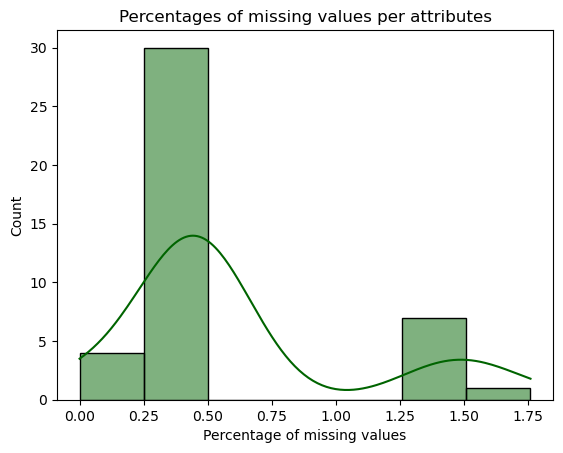

<IPython.core.display.Javascript object>

In [92]:
# Looking at the percentage of missing values for each attribute
sns.histplot(
    ((player_attributes.isnull().sum() / player_attributes.shape[0] * 100).round(2)),
    kde=True,
    color="darkgreen",
)
plt.title("Percentages of missing values per attributes")
plt.xlabel("Percentage of missing values")
plt.show()

---
- We can see that the maximum number of missing values percentage is 1.75%, which doesnt seem to be that high (less than 5%)

---

#### Looking at differences between data summaries of attributes with and without missing data rows

In [93]:
# Normalizing player_attributes to compare
numeric_cols = player_attributes.select_dtypes(include=["float64", "int64"]).columns

# Calculate mean and std only for numeric columns, these values per column attribute
mean = player_attributes[numeric_cols].mean()
std = player_attributes[numeric_cols].std()

# Perform Z-score normalization
normalized_df = (player_attributes[numeric_cols] - mean) / std

<IPython.core.display.Javascript object>

In [94]:
# Looking at potential changes if I remove the missing values
norm_diff = normalized_df.describe() - normalized_df.dropna().describe()
norm_diff

,id,player_fifa_api_id,player_api_id,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
count,2713.000000,2713.000000,2713.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,0.000000e+00,...,0.000000e+00,1877.000000,1877.000000,1877.000000,0.000000e+00,1877.000000,1877.000000,1877.000000,1877.00000,1877.000000
mean,0.000334,-0.016195,-0.009816,-0.003050,-0.001713,-0.001865,-0.000946,0.000737,-0.002129,-2.665540e-18,...,-1.724761e-18,0.004376,0.001398,0.000737,-2.195150e-18,-0.000548,0.005230,0.017190,0.00516,0.004724
std,0.000085,0.014098,-0.003583,0.001604,0.001608,-0.000565,-0.000467,0.000190,0.000528,0.000000e+00,...,0.000000e+00,-0.000794,-0.000158,-0.000633,0.000000e+00,0.000077,0.000135,0.011147,0.00012,-0.000395
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000
25%,-0.000315,-0.011810,-0.004922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000913,-0.004160,-0.011532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000861,-0.004810,-0.010911,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000,0.094217,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000


<IPython.core.display.Javascript object>

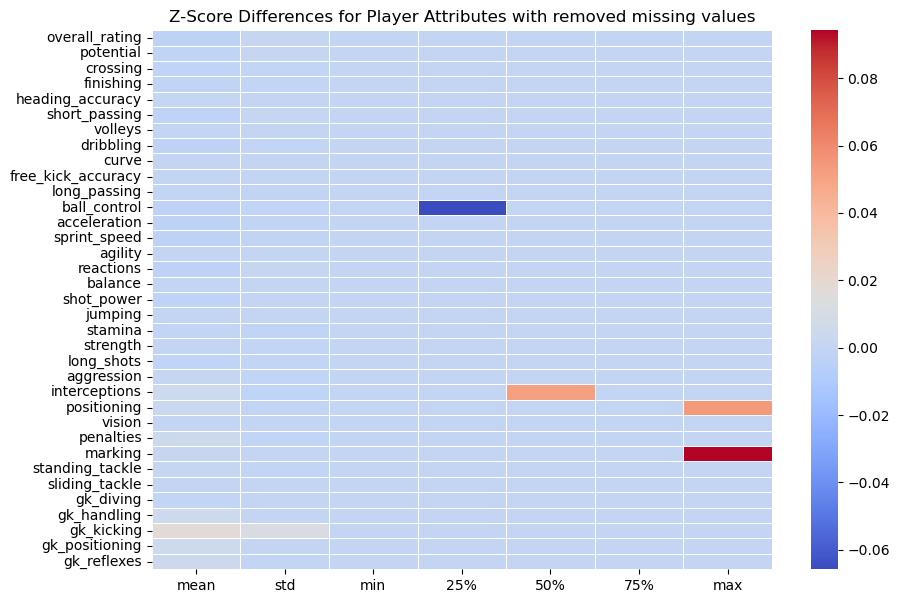

<IPython.core.display.Javascript object>

In [95]:
# Heatmap of Z score normalized values of 5 number summary and features if NaN get removed
plt.figure(figsize=(10, 7))
sns.heatmap(norm_diff.iloc[1:, 3:].T, cmap="coolwarm", linewidths=0.5)
plt.title("Z-Score Differences for Player Attributes with removed missing values")
plt.show()

---
- Overall difference doesnt seem to be that meaningfull
- Possible mean diffrence effect in gk_kicking, and some max outlier effects, but the difference seems quite small. Looking at the range of differences from .08 to -.06

- No substantial changes in attribute mean values otherwise that would suggest removing missing values would effect analysis negatively
---

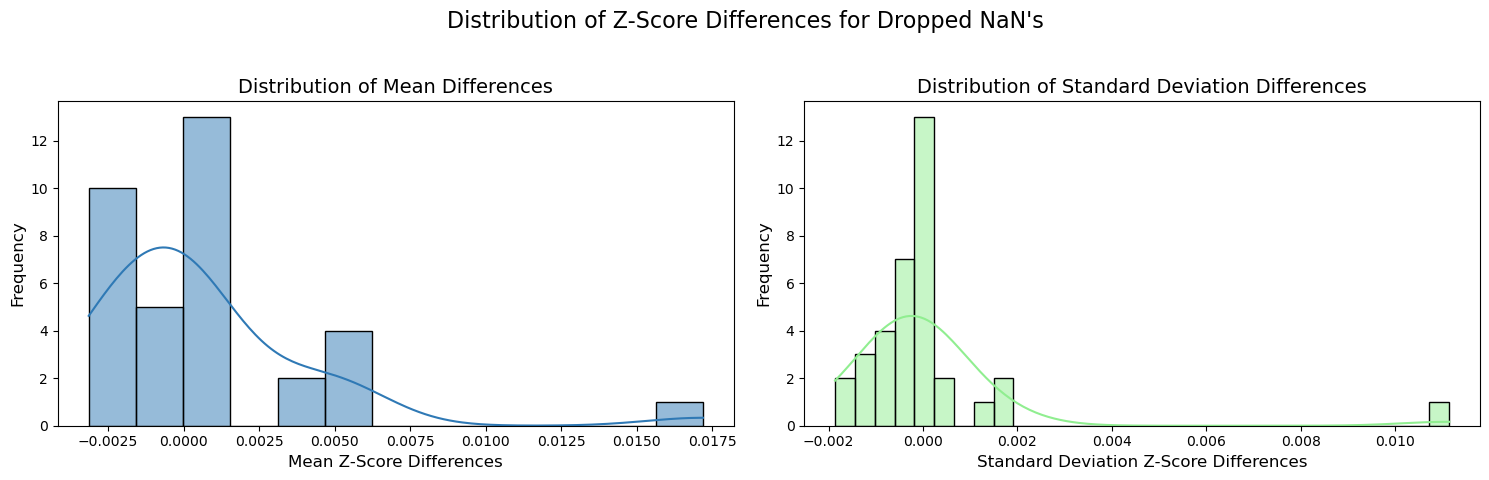

<IPython.core.display.Javascript object>

In [96]:
# Looking at mean and std distribution in more detail
# Create a side-by-side plot for mean and standard deviation differences
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Distribution of Z-Score Differences for Dropped NaN's", fontsize=16)

# Distribution of mean differences
sns.histplot(norm_diff.iloc[1, 3:], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Mean Differences", fontsize=14)
axes[0].set_xlabel("Mean Z-Score Differences", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# Distribution of standard deviation differences
sns.histplot(norm_diff.iloc[2, 3:], kde=True, ax=axes[1], color="lightgreen")
axes[1].set_title("Distribution of Standard Deviation Differences", fontsize=14)
axes[1].set_xlabel("Standard Deviation Z-Score Differences", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

---
- Again changes in values seems very small, but with some indicators of outliers, which might be having an important effect
---

#### Groups of missing values analysis

In [97]:
# Separating only the rows with any missing value in any column
is_null_df = player_attributes.isnull()
indexes_with_nan = list(is_null_df[is_null_df.any(axis=1)].index)

<IPython.core.display.Javascript object>

In [98]:
is_null_df[is_null_df.any(axis=1)].head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
373,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
374,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
375,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
376,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
377,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


<IPython.core.display.Javascript object>

In [99]:
# Checking for intersecting features missing values
set1 = set(group_836)
set2 = set(group_2713)
set3 = set(group_3230)

common_between_1_and_2 = set1.intersection(set2)
common_between_1_and_3 = set1.intersection(set3)
common_between_2_and_3 = set2.intersection(set3)

common_between_1_and_2, common_between_1_and_3, common_between_2_and_3

(set(), set(), set())

<IPython.core.display.Javascript object>

---
- No feature overlap between the groups
- Indicating some systematic reason for these missing values, we would expect some overlap if it was arbitrary
---

In [100]:
# Getting index values of the missing groups values
# 836 group
index_list_836 = list(
    is_null_df[is_null_df.any(axis=1)]
    .loc[:, group_836][is_null_df[is_null_df.any(axis=1)].loc[:, group_836].any(axis=1)]
    .index
)

# 2713 group
index_list_2713 = list(
    is_null_df[is_null_df.any(axis=1)]
    .loc[:, group_2713][
        is_null_df[is_null_df.any(axis=1)].loc[:, group_2713].any(axis=1)
    ]
    .index
)

# 3230 group
index_list_3230 = list(
    is_null_df[is_null_df.any(axis=1)]
    .loc[:, group_3230][
        is_null_df[is_null_df.any(axis=1)].loc[:, group_3230].any(axis=1)
    ]
    .index
)

<IPython.core.display.Javascript object>

In [101]:
# Example of parsed attributes for missing values from 2713 group
player_attributes.iloc[index_list_2713, :].head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
446,447,52782,38423,2010-02-22,68.0,70.0,right,None,_0,60.0,...,NaN,47.0,52.0,50.0,NaN,7.0,20.0,62.0,20.0,20.0
447,448,52782,38423,2009-08-30,68.0,70.0,right,None,_0,60.0,...,NaN,47.0,52.0,50.0,NaN,7.0,20.0,62.0,20.0,20.0
448,449,52782,38423,2008-08-30,68.0,69.0,right,None,_0,60.0,...,NaN,47.0,52.0,50.0,NaN,7.0,20.0,62.0,20.0,20.0
449,450,52782,38423,2007-08-30,70.0,69.0,right,None,_0,60.0,...,NaN,47.0,52.0,50.0,NaN,7.0,20.0,62.0,20.0,20.0
450,451,52782,38423,2007-02-22,70.0,69.0,right,None,_0,60.0,...,NaN,47.0,72.0,70.0,NaN,7.0,7.0,62.0,12.0,5.0


<IPython.core.display.Javascript object>

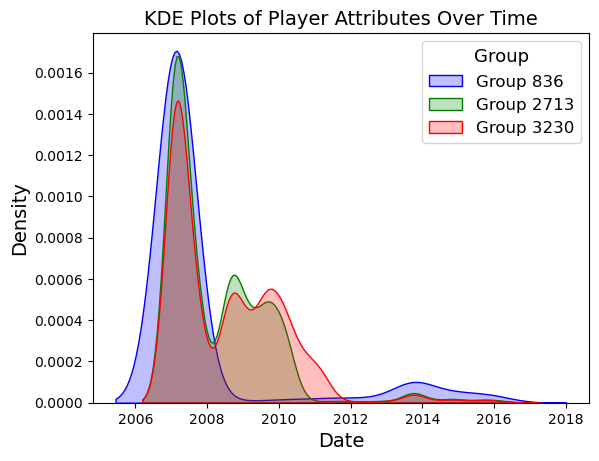

<IPython.core.display.Javascript object>

In [102]:
# KDE plot of the missing values groups overlaps in date terms
sns.kdeplot(
    player_attributes.iloc[index_list_836, :]["date"],
    label="Group 836",
    shade=True,
    color="blue",
)
sns.kdeplot(
    player_attributes.iloc[index_list_2713, :]["date"],
    label="Group 2713",
    shade=True,
    color="green",
)
sns.kdeplot(
    player_attributes.iloc[index_list_3230, :]["date"],
    label="Group 3230",
    shade=True,
    color="red",
)
plt.title("KDE Plots of Player Attributes Over Time", fontsize=14)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(title="Group", title_fontsize="13", fontsize="12")
plt.show()

-----
- We could argue that we can remove missing values data possibly only before 2008, since all three groups have simmilar distributions there, but removing missing values from 2008 might not be smart given that missing values are not "missing in the same sense"
----

**Visualizing missing features per group separately**

---


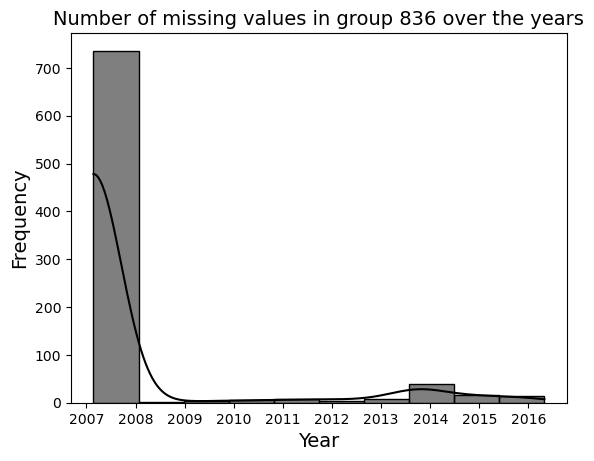

<IPython.core.display.Javascript object>

In [103]:
# Group 836 missing values
sns.histplot(
    player_attributes.iloc[index_list_836, :]["date"],
    bins=10,
    alpha=0.5,
    color="black",
    kde=True,
)
plt.title("Number of missing values in group 836 over the years", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

---
- **Attributes in this group**:  'overall_rating',
 'potential',
 'preferred_foot',
 'defensive_work_rate',
 'crossing',
 'finishing',
 'heading_accuracy',
 'short_passing',
 'dribbling',
 'free_kick_accuracy',
 'long_passing',
 'ball_control',
 'acceleration',
 'sprint_speed',
 'reactions',
 'shot_power',
 'stamina',
 'strength',
 'long_shots',
 'aggression',
 'interceptions',
 'positioning',
 'penalties',
 'marking',
 'standing_tackle',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_positioning',
 'gk_reflexes'


---
- We can see almost all missing values happening until early 2008
- This could point to these attributes being measured from early 2008 onwards, and them not being measured bfefore thet. Goven that data doesnt go older, we dont know. 

---

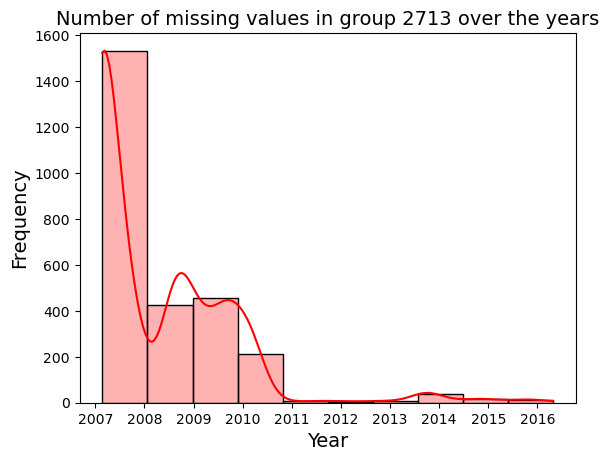

<IPython.core.display.Javascript object>

In [104]:
# Group 2713 missing values
sns.histplot(
    player_attributes.iloc[index_list_2713, :]["date"],
    bins=10,
    alpha=0.3,
    color="red",
    kde=True,
)
plt.title("Number of missing values in group 2713 over the years", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

---
- **Attributes in this group**: 'volleys',
 'curve',
 'agility',
 'balance',
 'jumping',
 'vision',
 'sliding_tackle'

---
- We can see trend of decreasing number of missing values in this group of attributes
- Big drop in the same period 2007-early 2008 as in group 836, suggesting some connection
- Decrease happens over few years, not in an instant like group 835
- Possibly slower adoption or measurements of these player attributes

---

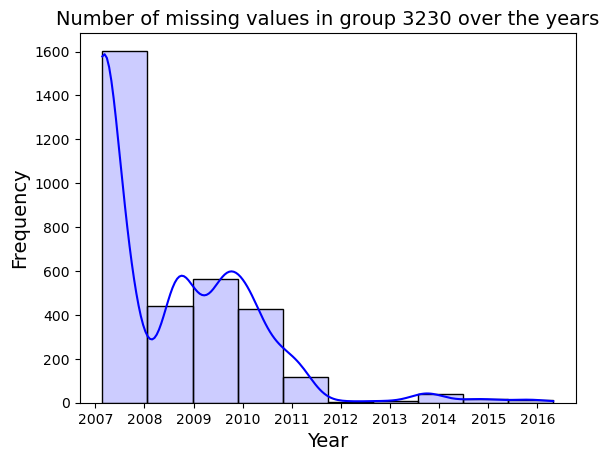

<IPython.core.display.Javascript object>

In [105]:
# Group 3230 missing values
sns.histplot(
    player_attributes.iloc[index_list_3230, :]["date"],
    bins=10,
    alpha=0.2,
    color="blue",
    kde=True,
)
plt.title("Number of missing values in group 3230 over the years", fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

---

- **Attribute in this group:** 'attacking_work_rate'

---

- Reduction of this missing attribute value even more gradual, additional year longer than previously
----

### Looking at duplicate values

In [106]:
# Looking at duplicates
for col in player_attributes.columns:
    print(f"{col}: {player_attributes[col].duplicated(keep=False).sum()}")

id: 0
player_fifa_api_id: 183978
player_api_id: 183978
date: 183976
overall_rating: 183978
potential: 183978
preferred_foot: 183978
attacking_work_rate: 183978
defensive_work_rate: 183978
crossing: 183977
finishing: 183977
heading_accuracy: 183977
short_passing: 183978
volleys: 183978
dribbling: 183977
curve: 183978
free_kick_accuracy: 183977
long_passing: 183977
ball_control: 183977
acceleration: 183975
sprint_speed: 183977
agility: 183977
reactions: 183977
balance: 183978
shot_power: 183977
jumping: 183976
stamina: 183976
strength: 183975
long_shots: 183977
aggression: 183976
interceptions: 183976
positioning: 183978
vision: 183978
penalties: 183977
marking: 183977
standing_tackle: 183977
sliding_tackle: 183978
gk_diving: 183976
gk_handling: 183976
gk_kicking: 183977
gk_positioning: 183976
gk_reflexes: 183978


<IPython.core.display.Javascript object>

---
- We can see a lot of duplicates in all columns, **multiple instances of same player measurements**, 'player_api_id' also having duplicates
---

In [107]:
# Checking unique players
player_attributes["player_api_id"].nunique()

11060

<IPython.core.display.Javascript object>

---
- We have **11060 players in this dataset** based on the unique values of player_api_id
---

In [108]:
# Checking if player data has same ammount of players as in player_attr.
player.shape

(11060, 7)

<IPython.core.display.Javascript object>

In [109]:
player.shape[0] - player_attributes["player_api_id"].nunique()

0

<IPython.core.display.Javascript object>

---
- Same ammount of players in both dataframes
---

### Removing missing values or no?
- Looking at the differences between wouldbe removed players, given that they have any missing atttribute, and players that dont have missing values. Trying to understand the potential systematic difference between these.

- We will proceed as if we would remove them and compare:

In [110]:
# Removing the missing values from players_attributes
player_attributes_r = player_attributes.dropna()

<IPython.core.display.Javascript object>

In [111]:
player.shape[0] - player_attributes_r["player_api_id"].nunique()

650

<IPython.core.display.Javascript object>

---
- There are 650 players less in attribute data once we delete the missing values.
- By deleting missing values of some attributes we loose 650 players from the data
---

#### Looking at players that have missing values in more dertail

In [112]:
# Player IDs that are in 'player_attributes' but not in 'player_attributes_r'
missing_player_ids = player_attributes.loc[
    ~player_attributes["player_api_id"].isin(player_attributes_r["player_api_id"]),
    "player_api_id",
]

<IPython.core.display.Javascript object>

In [113]:
# Checking that is is 650
missing_player_ids.nunique()

650

<IPython.core.display.Javascript object>

In [114]:
# Use this list to filter player_attributes
missing_players_df = player_attributes[
    player_attributes["player_api_id"].isin(missing_player_ids)
]

<IPython.core.display.Javascript object>

In [115]:
missing_players_df.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
373,374,156626,46447,2010-08-30,64.0,71.0,right,None,_0,41.0,...,61.0,39.0,62.0,61.0,57.0,15.0,14.0,13.0,10.0,12.0
374,375,156626,46447,2010-02-22,64.0,71.0,right,None,_0,41.0,...,61.0,58.0,62.0,61.0,57.0,6.0,20.0,45.0,20.0,20.0
375,376,156626,46447,2008-08-30,66.0,71.0,right,None,_0,41.0,...,61.0,58.0,67.0,61.0,57.0,6.0,20.0,45.0,20.0,20.0
376,377,156626,46447,2007-08-30,68.0,75.0,right,None,_0,41.0,...,61.0,58.0,69.0,64.0,57.0,6.0,20.0,45.0,20.0,20.0
377,378,156626,46447,2007-02-22,66.0,65.0,right,None,_0,41.0,...,61.0,55.0,66.0,63.0,57.0,6.0,9.0,45.0,13.0,10.0


<IPython.core.display.Javascript object>

---
-  We will omit non-numeric attributes to perform Z-score normalization. This enables a direct comparison between the average attributes of players with complete data and the 650 players who would be removed due to missing values. If these differences are significant, we might want to keep all of the players. 
---

In [116]:
# Perform Z-score normalization
normalized_df = (player_attributes[numeric_cols] - mean) / std
normalized_missing_df = (
    player_attributes[player_attributes["player_api_id"].isin(missing_player_ids)][
        numeric_cols
    ]
    - mean
) / std

# Calculate the descriptive statistics
result_zscore = normalized_df.describe().round(
    2
) - normalized_missing_df.describe().round(2)

<IPython.core.display.Javascript object>

In [117]:
result_zscore.iloc[1:, 3:]

,overall_rating,potential,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
mean,0.32,0.19,0.21,0.14,-0.01,0.26,0.22,0.33,0.39,0.04,...,-0.07,-0.29,-0.05,0.01,0.26,-0.03,-0.47,-1.42,-0.47,-0.44
std,-0.07,-0.08,0.04,0.02,-0.04,-0.06,-0.02,0.04,-0.04,-0.04,...,0.12,0.09,0.00,0.04,-0.02,-0.09,0.01,0.11,0.00,0.05
min,-1.14,-1.22,-0.24,-0.11,0.00,-0.57,-0.27,-0.28,-0.16,-0.22,...,-0.86,-0.32,-0.15,-0.19,-0.14,0.00,0.00,-0.18,0.00,0.00
25%,0.43,0.30,0.23,0.10,0.00,0.35,0.17,0.57,0.43,-0.11,...,-0.20,-0.38,0.00,-0.08,0.19,0.00,-0.76,-1.68,-0.75,-0.70
50%,0.43,0.30,0.29,0.26,-0.06,0.28,0.22,0.45,0.50,0.05,...,-0.07,-0.26,-0.10,0.04,0.51,0.06,-0.63,-2.05,-0.62,-0.59
75%,0.24,0.15,0.28,0.16,0.00,0.21,0.28,0.34,0.38,0.05,...,0.19,-0.19,0.00,0.10,0.19,0.00,-0.51,-2.33,-0.50,-0.46
max,0.43,0.76,0.23,0.21,0.30,0.29,0.71,0.22,0.50,0.17,...,0.33,0.13,0.00,0.09,0.56,0.53,0.06,0.23,0.43,0.35


<IPython.core.display.Javascript object>

How to interpret: 

Positive Mean Z-score: The missing values for this attribute are generally higher than the overall dataset. The greater the Z-score, the more significant this difference is.

Negative Mean Z-score: The missing values for this attribute are generally lower than the overall dataset. The lower the Z-score (more negative), the more significant this difference is.

Mean Z-score Close to Zero: The missing values for this attribute are roughly similar to the overall dataset.

---
For standard deviation (std):

Std Greater Than 1: The missing values for this attribute are more variable than the overall dataset.

Std Less Than 1: The missing values for this attribute are less variable than the overall dataset.

Std Close to 1: The missing values for this attribute have similar variability to the overall dataset.



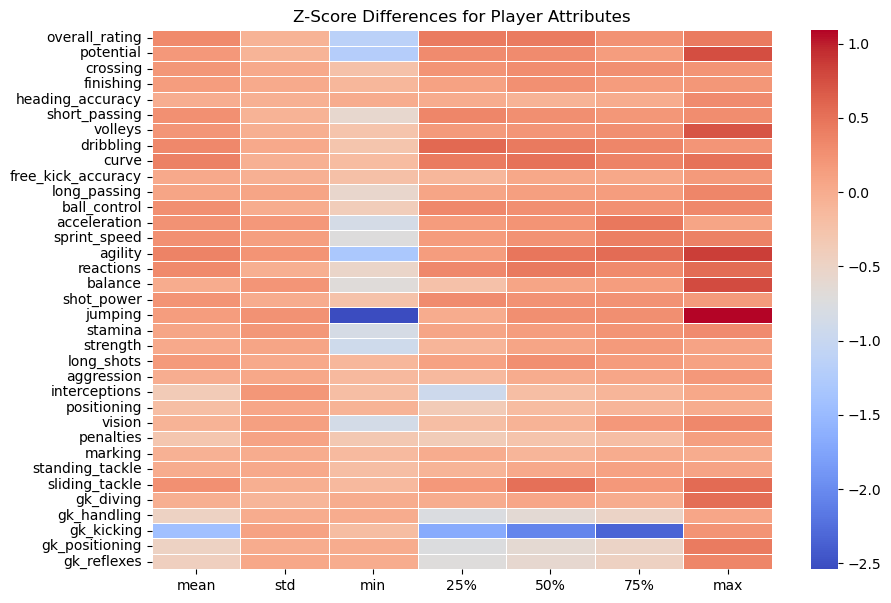

<IPython.core.display.Javascript object>

In [118]:
# Creating a heatmap of this in order to more easily understand the differences
plt.figure(figsize=(10, 7))
sns.heatmap(result_zscore.iloc[1:, 3:].T, cmap="coolwarm", linewidths=0.5)
plt.title("Z-Score Differences for Player Attributes")
plt.show()

---
- Min values seem to carry the most of the differences between averages of 650 potentially deleted players and rest

- The missing players tend to have lower extreme values for these attributes compared to the entire population of players. This could indicate that the missing data might be more likely to occur among players with lower attribute rating, possibly indicating less professional players or clubs
- Darker color for max value of the potential of the player, indicates in the missing attributes df, player might have higher potential 
- With regards to arguably most important, mean and std, seems quite uniform with only 'gk_kicking' being visibly lower
---


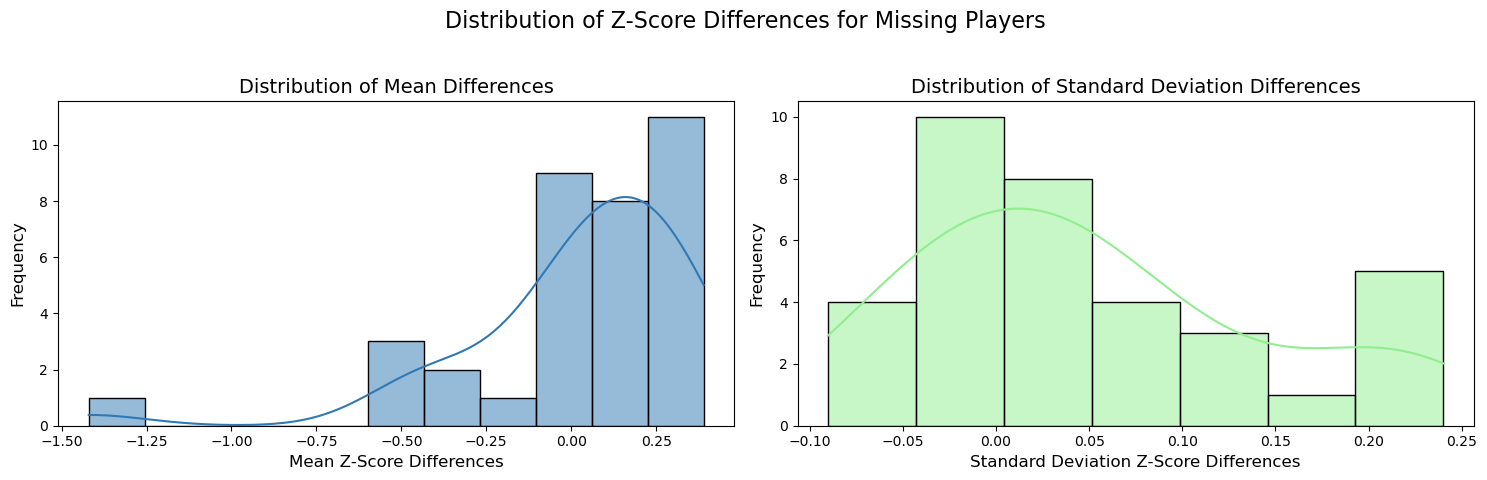

<IPython.core.display.Javascript object>

In [119]:
# Looking at mean and std distribution in more detail

# Create a side-by-side plot for mean and standard deviation differences
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Distribution of Z-Score Differences for Missing Players", fontsize=16)

# Distribution of mean differences
sns.histplot(result_zscore.iloc[1, 3:], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Mean Differences", fontsize=14)
axes[0].set_xlabel("Mean Z-Score Differences", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# Distribution of standard deviation differences
sns.histplot(result_zscore.iloc[2, 3:], kde=True, ax=axes[1], color="lightgreen")
axes[1].set_title("Distribution of Standard Deviation Differences", fontsize=14)
axes[1].set_xlabel("Standard Deviation Z-Score Differences", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

---
**Mean Differences** (Left Histogram)

- Most of the values are clustered around zero, but there is skew towards the negative side, missing players generally have lower attributes values

----

**Standard Deviation Differences** (Right Histogram)

- Most values are close to zero, variation in attributes for the missing players is similar to those in the overall dataset. Indicating potential differences mostly in the outlier values of attributes rather than overall variation. 



### Player attributes Descriptive Analysis and Feature Engeneering

In [120]:
player_attributes.iloc[:, 4:]

,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183973,83.0,85.0,right,medium,low,84.0,77.0,59.0,89.0,77.0,...,88.0,83.0,22.0,31.0,30.0,9.0,20.0,84.0,20.0,20.0
183974,78.0,80.0,right,medium,low,74.0,76.0,53.0,84.0,77.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183975,77.0,80.0,right,medium,low,74.0,71.0,53.0,84.0,77.0,...,88.0,70.0,32.0,31.0,30.0,9.0,20.0,73.0,20.0,20.0
183976,78.0,81.0,right,medium,low,74.0,64.0,57.0,86.0,77.0,...,88.0,53.0,28.0,32.0,30.0,9.0,20.0,73.0,20.0,20.0


<IPython.core.display.Javascript object>

##### Ordinal mapping

In [121]:
# Ordinal mapping

# Convert 'preferred_foot' into numerical values
foot_mapping = {'right': 0, 'left': 1}
player_attributes['preferred_foot'] = player_attributes['preferred_foot'].map(foot_mapping)

# Filter and convert 'defensive_work_rate' into numerical values
def_work_rate_mapping = {'low': 0, 'medium': 1, 'high': 2}
player_attributes = player_attributes[player_attributes['defensive_work_rate'].isin(['low', 'medium', 'high'])]
player_attributes['defensive_work_rate'] = player_attributes['defensive_work_rate'].map(def_work_rate_mapping)

# Filter and convert 'attacking_work_rate' into numerical values
att_work_rate_mapping = {'low': 0, 'medium': 1, 'high': 2}
player_attributes = player_attributes[player_attributes['attacking_work_rate'].isin(['low', 'medium', 'high'])]
player_attributes['attacking_work_rate'] = player_attributes['attacking_work_rate'].map(att_work_rate_mapping)


<IPython.core.display.Javascript object>

In [122]:
player_attributes_correlation_matrix = abs(player_attributes.corr())

<IPython.core.display.Javascript object>

##### Correlation matrix and filtering of highly correlated features

In [123]:
# Correlation matrix
corr_matrix = player_attributes.corr()

# Create a mask for the upper triangle of the correlation matrix
upper = corr_matrix.where(pd.np.triu(pd.np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column].abs() > 0.8)]

# Drop the columns from the original dataframe
filtered_player_attributes = player_attributes.drop(player_attributes[to_drop], axis=1)

print(filtered_player_attributes.columns)

Index(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating',
       'potential', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'short_passing', 'free_kick_accuracy', 'acceleration', 'agility',
       'reactions', 'balance', 'shot_power', 'jumping', 'stamina', 'strength',
       'aggression', 'interceptions', 'vision', 'penalties', 'gk_diving',
       'gk_kicking'],
      dtype='object')


<IPython.core.display.Javascript object>

##### Combining data from match, to connect player and team that plared played most in

In [124]:
# Getting team_api_id for most games played per player in that team into player_att. data

# Extract relevant columns from the match dataframe
team_player_columns = match[
    [
        "home_team_api_id",
        "away_team_api_id",
        "home_player_1",
        "home_player_2",
        "home_player_3",
        "home_player_4",
        "home_player_5",
        "home_player_6",
        "home_player_7",
        "home_player_8",
        "home_player_9",
        "home_player_10",
        "home_player_11",
        "away_player_1",
        "away_player_2",
        "away_player_3",
        "away_player_4",
        "away_player_5",
        "away_player_6",
        "away_player_7",
        "away_player_8",
        "away_player_9",
        "away_player_10",
        "away_player_11",
    ]
]

# Dictionary to store player appearances for each team
player_team_dict = {}
for index, row in team_player_columns.iterrows():
    home_team = row["home_team_api_id"]
    away_team = row["away_team_api_id"]

    for i in range(1, 12):
        home_player = row[f"home_player_{i}"]
        away_player = row[f"away_player_{i}"]

        if not np.isnan(home_player):
            if home_player not in player_team_dict:
                player_team_dict[home_player] = {}
            player_team_dict[home_player][home_team] = (
                player_team_dict[home_player].get(home_team, 0) + 1
            )

        if not np.isnan(away_player):
            if away_player not in player_team_dict:
                player_team_dict[away_player] = {}
            player_team_dict[away_player][away_team] = (
                player_team_dict[away_player].get(away_team, 0) + 1
            )

# Assign the team with the most appearances to each player in the filtered_player_attributes dataframe
filtered_player_attributes["team_api_id"] = filtered_player_attributes[
    "player_api_id"
].apply(
    lambda x: max(player_team_dict.get(x, {}).items(), key=lambda y: y[1])[0]
    if x in player_team_dict
    else np.nan
)

<IPython.core.display.Javascript object>

In [125]:
# Merge the two dataframes on 'player_api_id'
filtered_player_attributes = filtered_player_attributes.merge(
    player[["player_api_id", "birthday", "height", "weight"]],
    on="player_api_id",
    how="left",
)

filtered_player_attributes["birthday"] = pd.to_datetime(
    filtered_player_attributes["birthday"]
)


filtered_player_attributes["bmi"] = (
    (filtered_player_attributes["weight"] * 0.4535923)
    / (filtered_player_attributes["height"] * filtered_player_attributes["height"])
    * 10000
).round(2)

<IPython.core.display.Javascript object>

In [126]:
# Realized potenrial feature

<IPython.core.display.Javascript object>

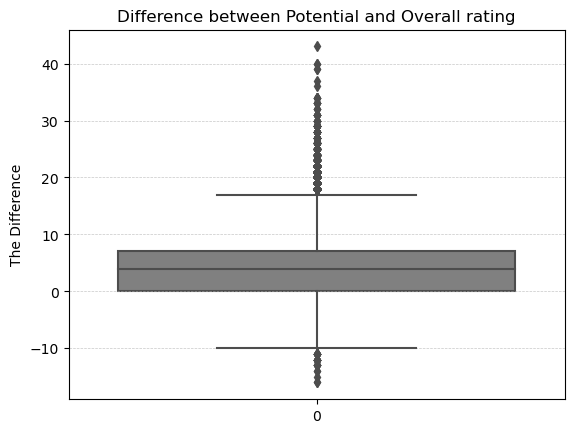

<IPython.core.display.Javascript object>

In [127]:
# Visualizing difference between potential and overall rating
sns.boxplot(
    filtered_player_attributes["potential"]
    - filtered_player_attributes["overall_rating"],
    color="grey",
)
plt.title("Difference between Potential and Overall rating")
plt.ylabel("The Difference")
plt.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()

In [128]:
(
    filtered_player_attributes["potential"]
    - filtered_player_attributes["overall_rating"]
).describe()

count    176161.000000
mean          4.828481
std           4.684812
min         -16.000000
25%           0.000000
50%           4.000000
75%           7.000000
max          43.000000
dtype: float64

<IPython.core.display.Javascript object>

In [129]:
# Checking for instances if overall rating is higher trhan potential
filtered_player_attributes[
    (
        filtered_player_attributes["potential"]
        - filtered_player_attributes["overall_rating"]
    )
    < 0
].shape

(983, 33)

<IPython.core.display.Javascript object>

- This indicating that these values cannot be combined as 'realized potential'

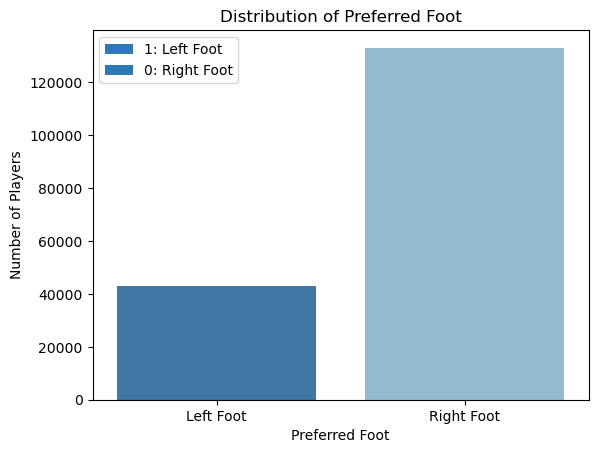

<IPython.core.display.Javascript object>

In [130]:
# Prefered foot visualized
sns.countplot(x="preferred_foot", data=filtered_player_attributes, order=[1, 0])
plt.xticks(ticks=[0, 1], labels=["Left Foot", "Right Foot"])
left_patch = mpatches.Patch(label="1: Left Foot")
right_patch = mpatches.Patch(label="0: Right Foot")
plt.legend(handles=[left_patch, right_patch])
plt.title("Distribution of Preferred Foot")
plt.ylabel("Number of Players")
plt.xlabel("Preferred Foot")
plt.show()

##### Choosing features to conduct VIF analysis on

In [131]:
filtered_player_attributes_VIF = filtered_player_attributes[
    [
        "overall_rating",
        "potential",
        "preferred_foot",
        "attacking_work_rate",
        "defensive_work_rate",
        "crossing",
        "finishing",
        "heading_accuracy",
        "short_passing",
        "free_kick_accuracy",
        "acceleration",
        "agility",
        "reactions",
        "balance",
        "shot_power",
        "jumping",
        "stamina",
        "strength",
        "aggression",
        "interceptions",
        "vision",
        "penalties",
        "gk_diving",
        "gk_kicking",
        "bmi",
    ]
]

<IPython.core.display.Javascript object>

In [132]:
# Normalizing data
scaler = StandardScaler()
# Fit and transform the data
normalized_data = scaler.fit_transform(filtered_player_attributes_VIF)
# Convert the result back to a DataFrame and use the original column names
normalized_df = pd.DataFrame(
    normalized_data, columns=filtered_player_attributes_VIF.columns
)
# Compute the VIF
# Add a constant to the model (required for the VIF calculation)
X = sm.add_constant(normalized_df)
# empty dataframe to store VIF values
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
# VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                Feature       VIF
0                 const  1.000000
1        overall_rating  5.961141
2             potential  2.875657
3        preferred_foot  1.075726
4   attacking_work_rate  1.230881
5   defensive_work_rate  1.242401
6              crossing  4.039773
7             finishing  4.548188
8      heading_accuracy  4.115314
9         short_passing  6.134650
10   free_kick_accuracy  3.099762
11         acceleration  3.606728
12              agility  3.865135
13            reactions  2.718790
14              balance  2.452007
15           shot_power  3.769648
16              jumping  1.475408
17              stamina  2.642500
18             strength  2.563958
19           aggression  2.794769
20        interceptions  3.063373
21               vision  3.738895
22            penalties  2.952097
23            gk_diving  6.656446
24           gk_kicking  1.874885
25                  bmi  1.126600


<IPython.core.display.Javascript object>

In [133]:
# VIF data for features with VIF values less than 5.1
vif_data_filtered = vif_data[vif_data["VIF"] < 5.1]
vif_selected_columns = vif_data_filtered["Feature"].values.tolist()

# Features to remove based on VIF values greater than 5.1
vif_data_to_rm = vif_data[vif_data["VIF"] > 5.1]
columns_to_remove = vif_data_to_rm["Feature"].values.tolist()

# Drop columns from the DataFrame
filtered_player_attributes.drop(columns=columns_to_remove, inplace=True)
filtered_player_attributes.drop(columns=["birthday", "height", "weight"], inplace=True)

<IPython.core.display.Javascript object>

In [134]:
filtered_player_attributes.columns.values

array(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'potential',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'crossing', 'finishing', 'heading_accuracy', 'free_kick_accuracy',
       'acceleration', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'aggression', 'interceptions',
       'vision', 'penalties', 'gk_kicking', 'team_api_id', 'bmi'],
      dtype=object)

<IPython.core.display.Javascript object>

In [135]:
selected_features = [
    "team_api_id",
    "potential",
    "preferred_foot",
    "attacking_work_rate",
    "defensive_work_rate",
    "crossing",
    "finishing",
    "heading_accuracy",
    "free_kick_accuracy",
    "acceleration",
    "agility",
    "reactions",
    "balance",
    "shot_power",
    "jumping",
    "stamina",
    "strength",
    "aggression",
    "interceptions",
    "vision",
    "penalties",
    "gk_kicking",
    "bmi",
]

<IPython.core.display.Javascript object>

In [136]:
filtered_player_attributes_for_agg = filtered_player_attributes[selected_features]

<IPython.core.display.Javascript object>

In [137]:
filtered_player_attributes_for_agg.columns.values

array(['team_api_id', 'potential', 'preferred_foot',
       'attacking_work_rate', 'defensive_work_rate', 'crossing',
       'finishing', 'heading_accuracy', 'free_kick_accuracy',
       'acceleration', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'aggression', 'interceptions',
       'vision', 'penalties', 'gk_kicking', 'bmi'], dtype=object)

<IPython.core.display.Javascript object>

In [138]:
# Aggregating the player attributes into team attributes based on common team
player_attributes_per_team_agg = (
    filtered_player_attributes_for_agg.groupby("team_api_id").mean().reset_index()
)

<IPython.core.display.Javascript object>

In [139]:
# team foot ratio
grouped = filtered_player_attributes_for_agg.groupby("team_api_id")[
    "preferred_foot"
].agg(["sum", "count"])

# Ratio of left-footed and right-footed players for each team
grouped["left_foot_ratio"] = grouped["sum"] / grouped["count"]
grouped["right_foot_ratio"] = 1 - grouped["left_foot_ratio"]

team_foot_ratio = grouped[["left_foot_ratio", "right_foot_ratio"]]

team_foot_ratio.head()

,left_foot_ratio,right_foot_ratio
team_api_id,,
1601.0,0.221388,0.778612
1773.0,0.287599,0.712401
1957.0,0.183099,0.816901
2033.0,0.161137,0.838863
2182.0,0.160227,0.839773


<IPython.core.display.Javascript object>

In [140]:
player_attributes_per_team_agg

,team_api_id,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,free_kick_accuracy,acceleration,...,shot_power,jumping,stamina,strength,aggression,interceptions,vision,penalties,gk_kicking,bmi
0,1601.0,65.529081,0.221388,1.243902,1.078799,47.870544,45.243902,50.637899,40.575985,62.654784,...,50.911820,65.292683,63.283302,61.472795,54.078799,45.469043,47.656660,46.739212,17.238274,22.749306
1,1773.0,68.327177,0.287599,1.163588,1.034301,51.408971,48.920844,54.709763,46.511873,65.659631,...,60.807388,64.860158,66.899736,66.437995,59.182058,45.042216,57.010554,54.258575,16.197889,22.756042
2,1957.0,66.834116,0.183099,1.031299,1.186228,48.194053,42.073552,49.449139,39.331768,65.655712,...,52.287950,63.870110,62.893584,62.225352,51.126761,44.286385,50.881064,47.001565,18.555556,23.133208
3,2033.0,70.872038,0.161137,1.139810,0.966825,55.236967,51.618483,59.353081,48.609005,67.428910,...,62.824645,66.966825,66.755924,67.111374,61.687204,49.478673,56.383886,53.834123,17.649289,23.313436
4,2182.0,70.311364,0.160227,1.277273,1.089773,51.950000,50.912500,55.623864,44.393182,68.078409,...,57.535227,67.313636,69.477273,67.378409,58.597727,49.460227,54.786364,50.245455,17.200000,23.193920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,158085.0,72.620915,0.333333,1.140523,1.003268,53.003268,45.696078,55.470588,45.663399,66.277778,...,60.836601,67.281046,65.967320,65.084967,61.624183,49.346405,53.415033,54.591503,13.058824,22.577712
292,177361.0,62.438596,0.263158,1.298246,0.894737,43.315789,46.824561,51.771930,36.798246,59.815789,...,53.912281,61.377193,60.763158,65.140351,55.298246,47.798246,51.868421,48.175439,16.640351,23.329123
293,188163.0,70.276190,0.000000,1.066667,0.980952,43.800000,44.523810,59.676190,41.371429,63.809524,...,58.447619,64.428571,63.800000,68.219048,57.400000,47.219048,51.133333,51.704762,15.600000,22.697333
294,208931.0,72.071661,0.081433,1.273616,1.009772,48.029316,45.918567,53.794788,40.283388,72.680782,...,54.723127,70.019544,68.872964,65.429967,54.511401,45.459283,45.081433,49.091205,12.400651,22.556906


<IPython.core.display.Javascript object>

#### Calculating 95% CI for the features

In [141]:
# Calculate means
means = player_attributes_per_team_agg.mean()

# Calculate standard deviations
std_devs = player_attributes_per_team_agg.std()

# Calculate the sample sizes
n = player_attributes_per_team_agg.count()

# Z value for 95% CI
Z = 1.96

# Calculate the margin of error
margin_errors = Z * (std_devs / np.sqrt(n))

# Calculate the lower and upper bounds for the CIs
lower_bounds = means - margin_errors
upper_bounds = means + margin_errors

# Create a dataframe for the results
df_results = pd.DataFrame(
    {"Mean": means, "95% CI Lower": lower_bounds, "95% CI Upper": upper_bounds}
)

print(df_results)

                             Mean  95% CI Lower  95% CI Upper
team_api_id          12383.618243   9413.834588  15353.401899
potential               72.228727     71.743639     72.713816
preferred_foot           0.243863      0.234071      0.253655
attacking_work_rate      1.186498      1.173384      1.199612
defensive_work_rate      1.023341      1.009355      1.037327
crossing                53.953961     53.354679     54.553242
finishing               49.046433     48.483990     49.608875
heading_accuracy        56.163439     55.606471     56.720407
free_kick_accuracy      48.448144     47.831979     49.064308
acceleration            66.813575     66.343287     67.283864
agility                 65.301012     64.890326     65.711699
reactions               65.109053     64.576715     65.641391
balance                 64.581089     64.222891     64.939286
shot_power              60.649381     60.026218     61.272543
jumping                 66.382920     66.062173     66.703668
stamina 

<IPython.core.display.Javascript object>

In [142]:
filtered_player_attributes_for_agg.columns.values

array(['team_api_id', 'potential', 'preferred_foot',
       'attacking_work_rate', 'defensive_work_rate', 'crossing',
       'finishing', 'heading_accuracy', 'free_kick_accuracy',
       'acceleration', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'aggression', 'interceptions',
       'vision', 'penalties', 'gk_kicking', 'bmi'], dtype=object)

<IPython.core.display.Javascript object>

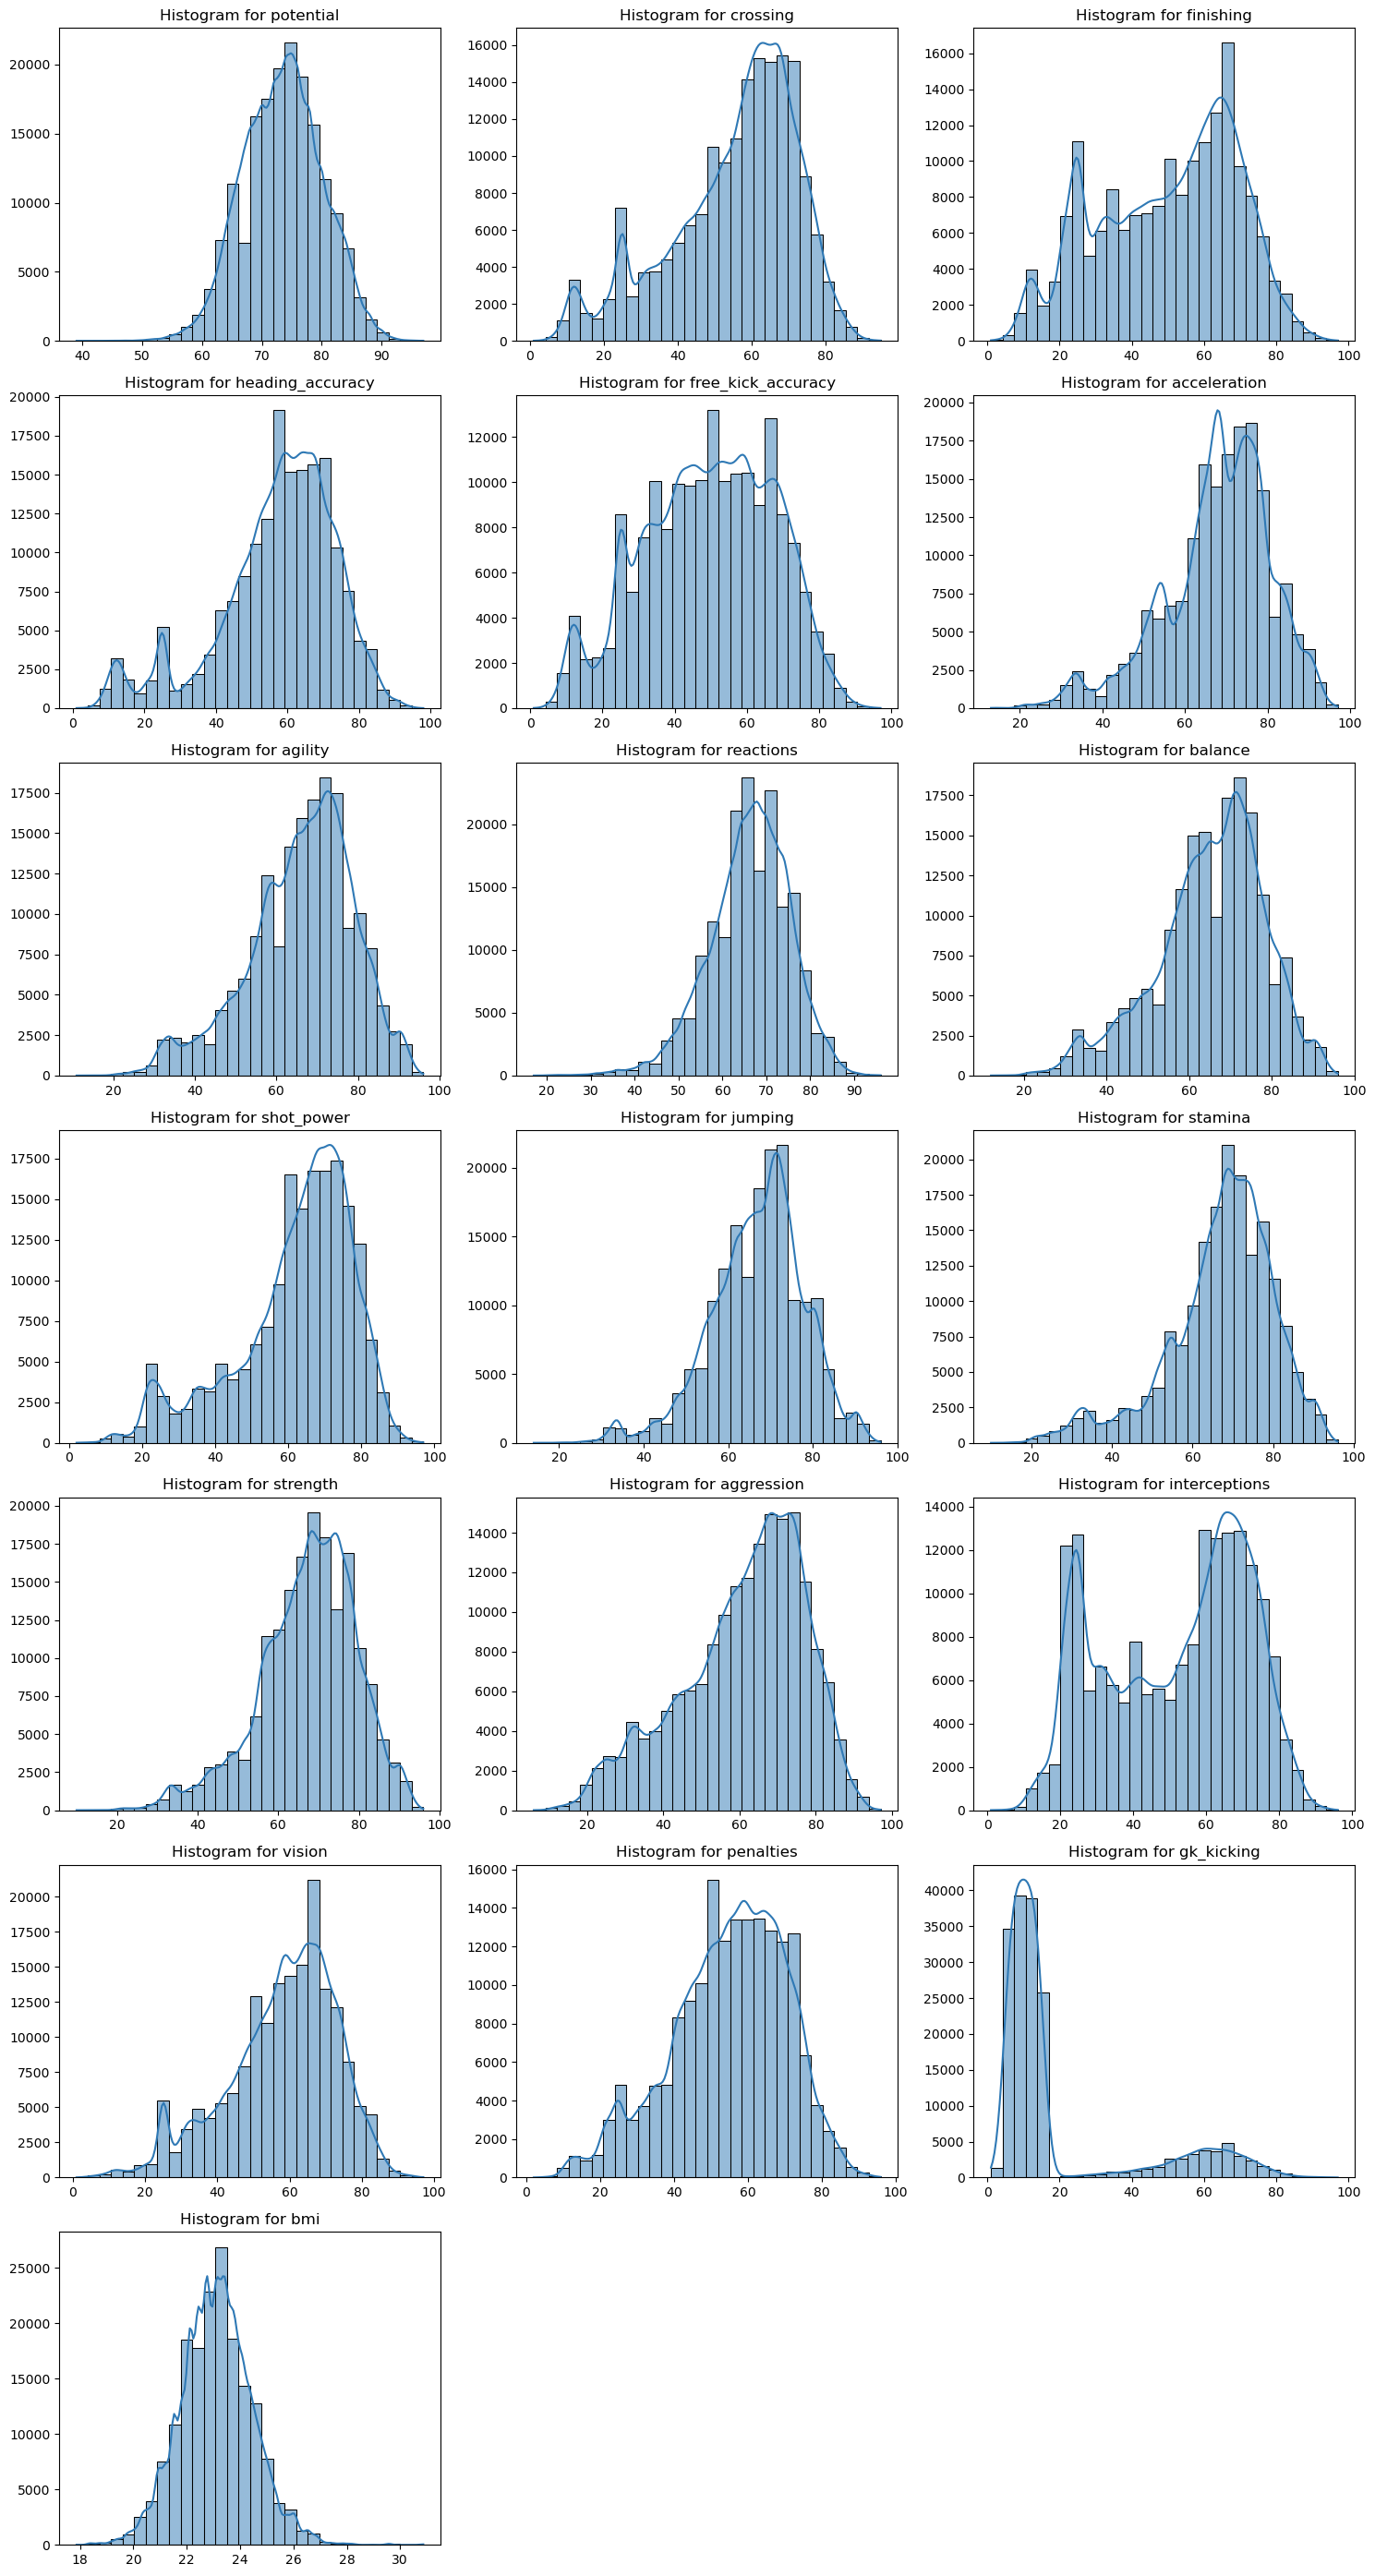

<IPython.core.display.Javascript object>

In [143]:
# features to visualize

features = [
    "potential",
    "crossing",
    "finishing",
    "heading_accuracy",
    "free_kick_accuracy",
    "acceleration",
    "agility",
    "reactions",
    "balance",
    "shot_power",
    "jumping",
    "stamina",
    "strength",
    "aggression",
    "interceptions",
    "vision",
    "penalties",
    "gk_kicking",
    "bmi",
]

#  size and layout of the plots
num_rows = len(features) // 3 + (len(features) % 3 > 0)
fig, axes = plt.subplots(num_rows, 3, figsize=(15, num_rows * 4))

for ax in axes.ravel():
    ax.axis("off")

for ax, feature in zip(axes.ravel(), features):
    sns.histplot(
        data=filtered_player_attributes_for_agg, x=feature, ax=ax, bins=30, kde=True
    )
    ax.set_title(f"Histogram for {feature}")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.axis("on")

plt.tight_layout()
plt.show()

- Most distributions follow simmilar bell shaped, with higher kurtosis
- There are few exceptions: interceptions, gk_kicking most significantly

#### Creating winning statistics dataframe

In [144]:
# Calculate home teams winning per team api id
h_wins = (match[match['home_team_outcome'] == 1]
          .groupby('home_team_api_id')['home_team_goal'].sum())

h_losses = (match[match['home_team_outcome'] == -1]
            .groupby('home_team_api_id')['home_team_goal'].sum())

h_draws = (match[match['home_team_outcome'] == 0]
           .groupby('home_team_api_id')['home_team_goal'].sum())

h_team_group = pd.concat([h_wins, h_losses, h_draws], axis=1, 
                         keys=['Wins', 'Losses', 'Draws'])

h_team_group['win_rate_total'] = (h_team_group['Wins'] / 
                                  (h_team_group['Losses'] + 
                                   h_team_group['Wins'] + 
                                   h_team_group['Draws']))

h_team_group['win_rate_decisive'] = (h_team_group['Wins'] / 
                                     (h_team_group['Losses'] + 
                                      h_team_group['Wins']))


<IPython.core.display.Javascript object>

In [145]:
h_team_group.head()

,Wins,Losses,Draws,win_rate_total,win_rate_decisive
home_team_api_id,,,,,
1601,111.0,20,17.0,0.750000,0.847328
1773,46.0,12,16.0,0.621622,0.793103
1957,135.0,16,25.0,0.767045,0.894040
2033,30.0,16,24.0,0.428571,0.652174
2182,182.0,9,24.0,0.846512,0.952880


<IPython.core.display.Javascript object>

In [146]:
# Calculate away teams winning per team api id
a_wins = (match[match['away_team_outcome'] == 1]
          .groupby('away_team_api_id')['away_team_goal'].sum())

a_losses = (match[match['away_team_outcome'] == -1]
            .groupby('away_team_api_id')['away_team_goal'].sum())

a_draws = (match[match['away_team_outcome'] == 0]
           .groupby('away_team_api_id')['away_team_goal'].sum())

a_team_group = pd.concat([a_wins, a_losses, a_draws], axis=1, 
                         keys=['Wins', 'Losses', 'Draws'])

a_team_group['win_rate_total'] = (a_team_group['Wins'] / 
                                  (a_team_group['Losses'] + 
                                   a_team_group['Wins'] + 
                                   a_team_group['Draws']))

a_team_group['win_rate_decisive'] = (a_team_group['Wins'] / 
                                     (a_team_group['Losses'] + 
                                      a_team_group['Wins']))


<IPython.core.display.Javascript object>

In [147]:
a_team_group.head()

,Wins,Losses,Draws,win_rate_total,win_rate_decisive
away_team_api_id,,,,,
1601,82,23,27,0.621212,0.780952
1773,15,18,19,0.288462,0.454545
1957,51,29,31,0.459459,0.637500
2033,25,13,30,0.367647,0.657895
2182,116,13,28,0.738854,0.899225


<IPython.core.display.Javascript object>

In [148]:
# prefixes to column names based on home/away grouping
h_team_group = h_team_group.add_prefix("h_")
a_team_group = a_team_group.add_prefix("a_")

h_team_group.index.name = "team_api_id"
a_team_group.index.name = "team_api_id"

# Merge dataframes on team_api_id
per_team_id_winrates = h_team_group.merge(a_team_group, on="team_api_id")

# Fill NaN values with 0
per_team_id_winrates.fillna(0, inplace=True)

# aggregated statistics
per_team_id_winrates["total_wins"] = (
    per_team_id_winrates["h_Wins"] + per_team_id_winrates["a_Wins"]
)
per_team_id_winrates["total_losses"] = (
    per_team_id_winrates["h_Losses"] + per_team_id_winrates["a_Losses"]
)
per_team_id_winrates["total_draws"] = (
    per_team_id_winrates["h_Draws"] + per_team_id_winrates["a_Draws"]
)
per_team_id_winrates["total_matches"] = (
    per_team_id_winrates["total_wins"]
    + per_team_id_winrates["total_losses"]
    + per_team_id_winrates["total_draws"]
)

# home-away win differential
per_team_id_winrates["HAWD"] = (
    per_team_id_winrates["h_Wins"] - per_team_id_winrates["a_Wins"]
) / (per_team_id_winrates["total_matches"] - per_team_id_winrates["total_draws"])

# home-away losses differential
per_team_id_winrates["HALD"] = (
    per_team_id_winrates["h_Losses"] - per_team_id_winrates["a_Losses"]
) / (per_team_id_winrates["total_matches"] - per_team_id_winrates["total_draws"])

# rates for wins, draws, and losses
per_team_id_winrates["total_win_rate"] = (
    per_team_id_winrates["total_wins"] / per_team_id_winrates["total_matches"]
)
per_team_id_winrates["total_draw_rate"] = (
    per_team_id_winrates["total_losses"] / per_team_id_winrates["total_matches"]
)
per_team_id_winrates["total_loosing_rate"] = (
    per_team_id_winrates["total_draws"] / per_team_id_winrates["total_matches"]
)

# Round the rates to 3 decimal places
per_team_id_winrates = per_team_id_winrates.round(3)

# Assign win rate deciles
per_team_id_winrates["win_rate_deciles"] = (
    pd.qcut(per_team_id_winrates["total_win_rate"], 10, labels=False) + 1
)

<IPython.core.display.Javascript object>

In [149]:
per_team_id_winrates.columns.values

array(['h_Wins', 'h_Losses', 'h_Draws', 'h_win_rate_total',
       'h_win_rate_decisive', 'a_Wins', 'a_Losses', 'a_Draws',
       'a_win_rate_total', 'a_win_rate_decisive', 'total_wins',
       'total_losses', 'total_draws', 'total_matches', 'HAWD', 'HALD',
       'total_win_rate', 'total_draw_rate', 'total_loosing_rate',
       'win_rate_deciles'], dtype=object)

<IPython.core.display.Javascript object>

In [150]:
per_team_id_winrates[["HAWD", "HALD"]].describe()

,HAWD,HALD
count,299.000000,299.000000
mean,0.207629,-0.029535
std,0.127989,0.078263
min,-0.375000,-0.286000
25%,0.133000,-0.067500
50%,0.209000,-0.036000
75%,0.277500,-0.006000
max,0.571000,0.375000


<IPython.core.display.Javascript object>

- On average home teams are 20% more likely to win. 

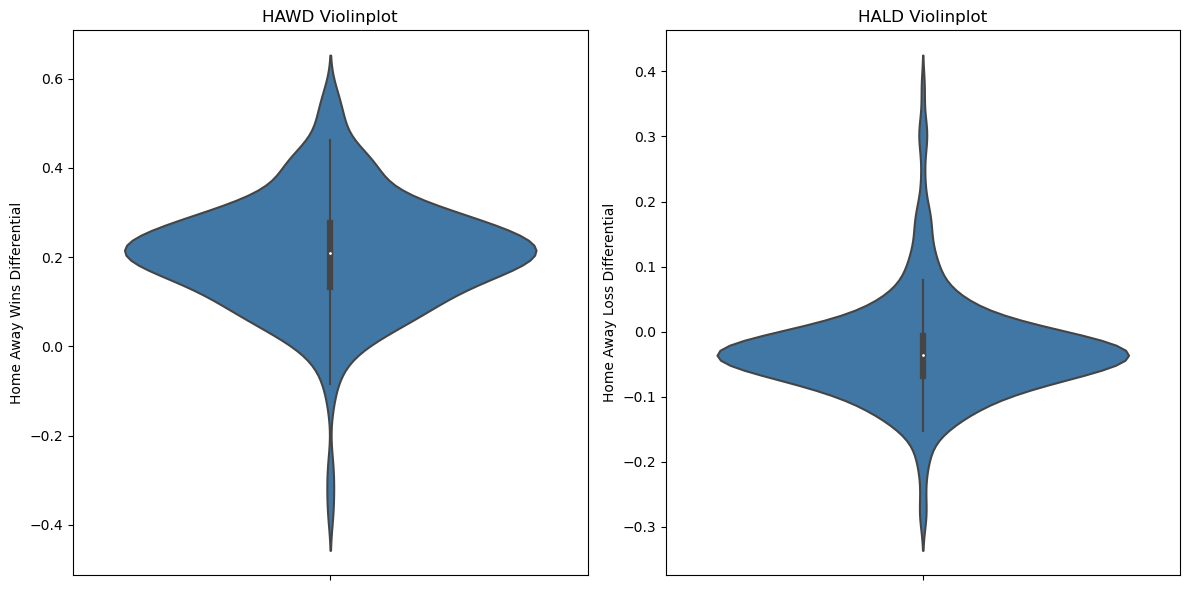

<IPython.core.display.Javascript object>

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.violinplot(y=per_team_id_winrates["HAWD"], ax=ax[0])
ax[0].set_title("HAWD Violinplot")
ax[0].set_ylabel("Home Away Wins Differential")
sns.violinplot(y=per_team_id_winrates["HALD"], ax=ax[1])
ax[1].set_title("HALD Violinplot")
ax[1].set_ylabel("Home Away Loss Differential")
plt.tight_layout()
plt.show()

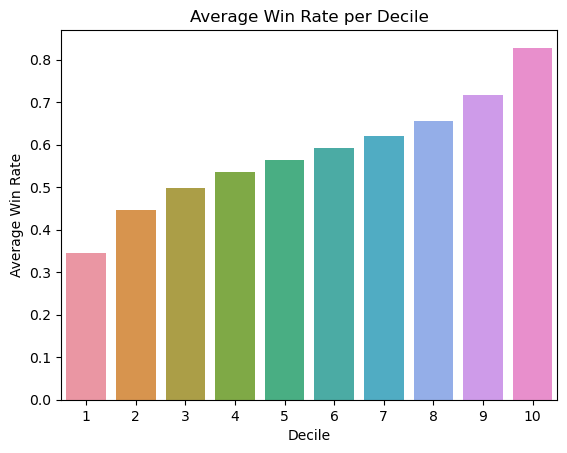

<IPython.core.display.Javascript object>

In [152]:
# Group by deciles and compute the average win rate
avg_win_rate_per_decile = per_team_id_winrates.groupby("win_rate_deciles")[
    "total_win_rate"
].mean()

# Plot
sns.barplot(x=avg_win_rate_per_decile.index, y=avg_win_rate_per_decile.values)
plt.title("Average Win Rate per Decile")
plt.ylabel("Average Win Rate")
plt.xlabel("Decile")
plt.show()

In [153]:
def gini(x):
    """Compute the Gini coefficient of a numpy array."""
    x = np.sort(x)  # sorted values
    n = len(x)
    cum_x = np.cumsum(x)  # cumulative values
    return (n + 1 - 2 * np.sum(cum_x) / cum_x[-1]) / n


win_rates = per_team_id_winrates["total_win_rate"].values
gini_coeff = gini(win_rates)
print(f"Gini Coefficient: {gini_coeff:.2f}")

Gini Coefficient: 0.13


<IPython.core.display.Javascript object>

- The distribution of win rates among the teams is relatively equitable, and there isn't a significant concentration of wins in just a few teams.

In [154]:
# adding the interaction columns, combined effects of 2 features
per_team_id_winrates["interaction_win"] = (
    per_team_id_winrates["h_Wins"] * per_team_id_winrates["a_Wins"]
)
per_team_id_winrates["interaction_loss"] = (
    per_team_id_winrates["h_Losses"] * per_team_id_winrates["a_Losses"]
)
per_team_id_winrates["interaction_draw"] = (
    per_team_id_winrates["h_Draws"] * per_team_id_winrates["a_Draws"]
)
per_team_id_winrates["interaction_win_rate_total"] = (
    per_team_id_winrates["h_win_rate_total"] * per_team_id_winrates["a_win_rate_total"]
)
per_team_id_winrates["interaction_win_rate_decisive"] = (
    per_team_id_winrates["h_win_rate_decisive"]
    * per_team_id_winrates["a_win_rate_decisive"]
)

<IPython.core.display.Javascript object>

- interaction_win:

    This captures the combined effect of home wins and away wins.
    Interpretation: Teams that have both high home and away wins might have an enhanced effect on the outcome than if considered separately. In other words, this could capture teams that maintain consistent performance both home and away.

- interaction_loss:

    This captures the combined effect of home losses and away losses.
    Interpretation: Teams that have high losses both at home and away might signify consistent underperformance across venues. The combined effect could be more detrimental than individual home or away losses.
- interaction_draw:

    Represents the combined effect of home draws and away draws.
    Interpretation: A team that frequently draws its matches, irrespective of the venue, could have a distinct style or approach to matches. This interaction captures the compound effect of such a pattern.
- interaction_win_rate_total:

    Combines the overall win rate at home and away.
    Interpretation: This feature will highlight teams that consistently have high win rates both at home and away. Such teams might demonstrate overarching dominance in the league or competition.
- interaction_win_rate_decisive:

    Combines the decisive win rate at home and away.
    Interpretation: Captures the joint effect of teams that have decisive victories, both at home and away. A high value could indicate teams that not only win but win convincingly, regardless of the venue.

In [155]:
per_team_id_winrates.columns.values

array(['h_Wins', 'h_Losses', 'h_Draws', 'h_win_rate_total',
       'h_win_rate_decisive', 'a_Wins', 'a_Losses', 'a_Draws',
       'a_win_rate_total', 'a_win_rate_decisive', 'total_wins',
       'total_losses', 'total_draws', 'total_matches', 'HAWD', 'HALD',
       'total_win_rate', 'total_draw_rate', 'total_loosing_rate',
       'win_rate_deciles', 'interaction_win', 'interaction_loss',
       'interaction_draw', 'interaction_win_rate_total',
       'interaction_win_rate_decisive'], dtype=object)

<IPython.core.display.Javascript object>

In [156]:
# Taking a subset of features
per_team_id_wr_subset = per_team_id_winrates[
    [
        "h_win_rate_total",
        "a_win_rate_total",
        "HAWD",
        "HALD",
        "interaction_win",
        "interaction_loss",
        "interaction_draw",
        "interaction_win_rate_total",
    ]
]

<IPython.core.display.Javascript object>

In [157]:
per_team_id_wr_subset_corr = per_team_id_wr_subset.corr()

<IPython.core.display.Javascript object>

In [158]:
per_team_id_wr_subset_corr

,h_win_rate_total,a_win_rate_total,HAWD,HALD,interaction_win,interaction_loss,interaction_draw,interaction_win_rate_total
h_win_rate_total,1.000000,0.565821,0.441664,-0.353046,0.596783,0.189910,0.405493,0.808574
a_win_rate_total,0.565821,1.000000,-0.368305,0.113655,0.666972,0.137000,0.416820,0.921922
HAWD,0.441664,-0.368305,1.000000,-0.292324,-0.018333,0.024101,0.009597,-0.063145
HALD,-0.353046,0.113655,-0.292324,1.000000,0.004025,-0.132871,-0.097175,-0.050592
interaction_win,0.596783,0.666972,-0.018333,0.004025,1.000000,0.086417,0.370981,0.790269
interaction_loss,0.189910,0.137000,0.024101,-0.132871,0.086417,1.000000,0.673912,0.131266
interaction_draw,0.405493,0.416820,0.009597,-0.097175,0.370981,0.673912,1.000000,0.437752
interaction_win_rate_total,0.808574,0.921922,-0.063145,-0.050592,0.790269,0.131266,0.437752,1.000000


<IPython.core.display.Javascript object>

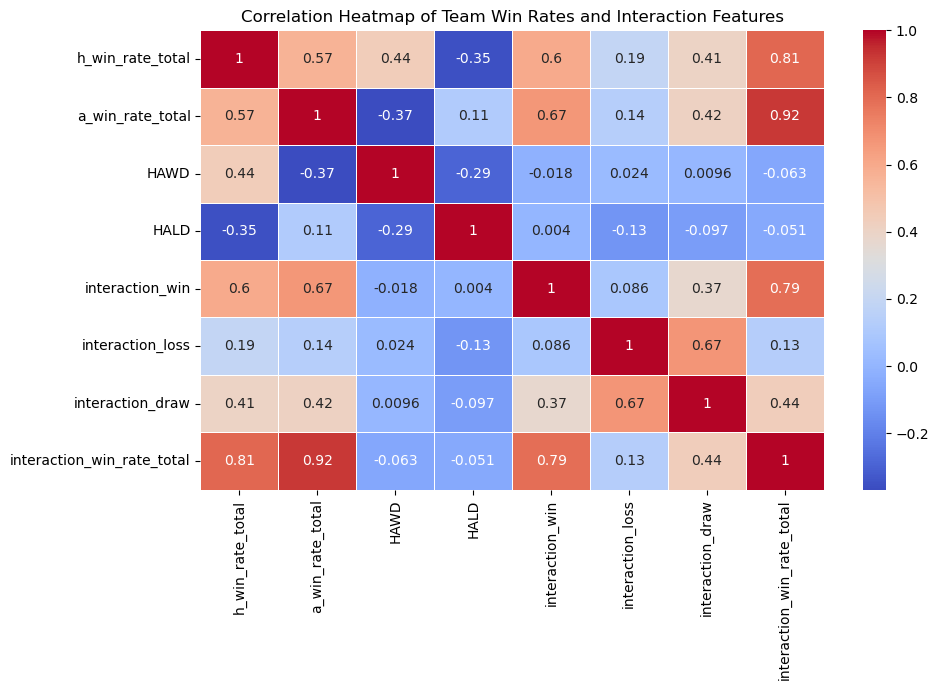

<IPython.core.display.Javascript object>

In [159]:
# Visualizing team winrates indicator correlations
plt.figure(figsize=(10, 7))
sns.heatmap(per_team_id_wr_subset_corr, cmap="coolwarm", linewidths=0.5, annot=True)
plt.title("Correlation Heatmap of Team Win Rates and Interaction Features")
plt.tight_layout()
plt.show()

- There are 2 high correlation features but I will leave themf time being

##### Doing VIF for winrate metrics

In [160]:
scaler = StandardScaler()
per_team_id_wr_subset_normalized = pd.DataFrame(
    scaler.fit_transform(per_team_id_wr_subset), columns=per_team_id_wr_subset.columns
)

df_with_const = pd.concat(
    [
        pd.Series(1, index=per_team_id_wr_subset_normalized.index, name="const"),
        per_team_id_wr_subset_normalized,
    ],
    axis=1,
)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = df_with_const.columns
vif["VIF Factor"] = [
    variance_inflation_factor(df_with_const.values, i)
    for i in range(df_with_const.shape[1])
]

vif = vif[vif["Feature"] != "const"]
vif

,Feature,VIF Factor
1,h_win_rate_total,19.694999
2,a_win_rate_total,32.676158
3,HAWD,4.750808
4,HALD,1.598792
5,interaction_win,4.234035
6,interaction_loss,2.057887
7,interaction_draw,2.419152
8,interaction_win_rate_total,74.875005


<IPython.core.display.Javascript object>

- I will remove the interaction_win_rate_total see if interaction winrate improves

In [161]:
# Drop 'a_win_rate_total'
per_team_id_wr_subset = per_team_id_wr_subset.drop("interaction_win_rate_total", axis=1)

scaler = StandardScaler()
per_team_id_wr_subset_normalized = pd.DataFrame(
    scaler.fit_transform(per_team_id_wr_subset), columns=per_team_id_wr_subset.columns
)


df_with_const = pd.concat(
    [
        pd.Series(1, index=per_team_id_wr_subset_normalized.index, name="const"),
        per_team_id_wr_subset_normalized,
    ],
    axis=1,
)


vif = pd.DataFrame()
vif["Feature"] = df_with_const.columns
vif["VIF Factor"] = [
    variance_inflation_factor(df_with_const.values, i)
    for i in range(df_with_const.shape[1])
]


vif = vif[vif["Feature"] != "const"]
vif

,Feature,VIF Factor
1,h_win_rate_total,7.788152
2,a_win_rate_total,7.134741
3,HAWD,4.730877
4,HALD,1.585270
5,interaction_win,2.134991
6,interaction_loss,1.977638
7,interaction_draw,2.416470


<IPython.core.display.Javascript object>

- We can see that it is imporved now, we will use these features as ones to merge with other ones

###### Selecting the VIF filtered features

In [162]:
# Selecting the VIF filtered features
selected_vif_features = vif["Feature"].to_list()
per_team_id_wr_subset = per_team_id_wr_subset[selected_vif_features]

<IPython.core.display.Javascript object>

In [163]:
per_team_id_wr_subset.reset_index(inplace=True)

<IPython.core.display.Javascript object>

In [164]:
per_team_id_wr_subset.shape

(299, 8)

<IPython.core.display.Javascript object>

In [165]:
player_attributes_per_team_agg.reset_index(inplace=True)

<IPython.core.display.Javascript object>

In [166]:
player_attributes_per_team_agg["team_api_id"] = player_attributes_per_team_agg[
    "team_api_id"
].astype(int)

<IPython.core.display.Javascript object>

In [167]:
player_attributes_per_team_agg.shape

(296, 24)

<IPython.core.display.Javascript object>

- The aggregated dataframes for teams differ by 3 team_api_id's
- This could be due to way I aggregated data, and combined player with most games played in a team, some player overlap with multiple teams might explain this. 
- I will merge these two, with loosing those 3 values, 1% of team_api_id's

In [168]:
player_attributes_merged_agg_final = player_attributes_per_team_agg.merge(
    per_team_id_wr_subset, on="team_api_id", how="inner"
)

<IPython.core.display.Javascript object>

In [169]:
# Checking for any missing values
player_attributes_merged_agg_final.isnull().sum().sum(), player_attributes_merged_agg_final.shape

(0, (296, 31))

<IPython.core.display.Javascript object>

- In this aggregated players attributes, we have merged two dataframes, both ran through VIF, and features with appropriate VIF levels selected
- We end up with 31 features for each team based on player attributes and match wins/looses

In [170]:
player_attributes_merged_agg_final.head()

,index,team_api_id,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,free_kick_accuracy,...,penalties,gk_kicking,bmi,h_win_rate_total,a_win_rate_total,HAWD,HALD,interaction_win,interaction_loss,interaction_draw
0,0,1601,65.529081,0.221388,1.243902,1.078799,47.870544,45.243902,50.637899,40.575985,...,46.739212,17.238274,22.749306,0.750,0.621,0.123,-0.013,9102.0,460,459.0
1,1,1773,68.327177,0.287599,1.163588,1.034301,51.408971,48.920844,54.709763,46.511873,...,54.258575,16.197889,22.756042,0.622,0.288,0.341,-0.066,690.0,216,304.0
2,2,1957,66.834116,0.183099,1.031299,1.186228,48.194053,42.073552,49.449139,39.331768,...,47.001565,18.555556,23.133208,0.767,0.459,0.364,-0.056,6885.0,464,775.0
3,3,2033,70.872038,0.161137,1.139810,0.966825,55.236967,51.618483,59.353081,48.609005,...,53.834123,17.649289,23.313436,0.429,0.368,0.060,0.036,750.0,208,720.0
4,4,2182,70.311364,0.160227,1.277273,1.089773,51.950000,50.912500,55.623864,44.393182,...,50.245455,17.200000,23.193920,0.847,0.739,0.206,-0.012,21112.0,117,672.0


<IPython.core.display.Javascript object>

#### Doing VIF on aggregated dataframe

In [171]:
# Normalizing data
scaler = StandardScaler()
player_attributes_merged_agg_final_normalized = pd.DataFrame(
    scaler.fit_transform(player_attributes_merged_agg_final),
    columns=player_attributes_merged_agg_final.columns,
)

df_with_const = pd.concat(
    [
        pd.Series(
            1, index=player_attributes_merged_agg_final_normalized.index, name="const"
        ),
        player_attributes_merged_agg_final_normalized,
    ],
    axis=1,
)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = df_with_const.columns
vif["VIF Factor"] = [
    variance_inflation_factor(df_with_const.values, i)
    for i in range(df_with_const.shape[1])
]

vif = vif[vif["Feature"] != "const"]
vif

,Feature,VIF Factor
1,index,1.318685
2,team_api_id,1.311752
3,potential,13.728231
4,preferred_foot,1.365056
5,attacking_work_rate,1.897336
6,defensive_work_rate,2.043367
7,crossing,9.724498
8,finishing,9.535933
9,heading_accuracy,6.645213
10,free_kick_accuracy,8.626909


<IPython.core.display.Javascript object>

- I will select features with VIF bellow 10

In [172]:
features_to_remove_vif_10 = vif[vif["VIF Factor"] > 10]["Feature"].to_list()

<IPython.core.display.Javascript object>

In [173]:
features_to_remove_vif_5 = vif[vif["VIF Factor"] > 5]["Feature"].to_list()

<IPython.core.display.Javascript object>

In [174]:
# Filtering the player_attributes based on VIF features
player_attributes_merged_agg_final_vif_dropped = (
    player_attributes_merged_agg_final.drop(features_to_remove_vif_10, axis=1)
)

<IPython.core.display.Javascript object>

#### Final Player Attributes aggregated vif filtered dataframe

In [175]:
player_attributes_merged_agg_final_vif_dropped.head()

,index,team_api_id,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,free_kick_accuracy,acceleration,...,penalties,gk_kicking,bmi,h_win_rate_total,a_win_rate_total,HAWD,HALD,interaction_win,interaction_loss,interaction_draw
0,0,1601,0.221388,1.243902,1.078799,47.870544,45.243902,50.637899,40.575985,62.654784,...,46.739212,17.238274,22.749306,0.750,0.621,0.123,-0.013,9102.0,460,459.0
1,1,1773,0.287599,1.163588,1.034301,51.408971,48.920844,54.709763,46.511873,65.659631,...,54.258575,16.197889,22.756042,0.622,0.288,0.341,-0.066,690.0,216,304.0
2,2,1957,0.183099,1.031299,1.186228,48.194053,42.073552,49.449139,39.331768,65.655712,...,47.001565,18.555556,23.133208,0.767,0.459,0.364,-0.056,6885.0,464,775.0
3,3,2033,0.161137,1.139810,0.966825,55.236967,51.618483,59.353081,48.609005,67.428910,...,53.834123,17.649289,23.313436,0.429,0.368,0.060,0.036,750.0,208,720.0
4,4,2182,0.160227,1.277273,1.089773,51.950000,50.912500,55.623864,44.393182,68.078409,...,50.245455,17.200000,23.193920,0.847,0.739,0.206,-0.012,21112.0,117,672.0


<IPython.core.display.Javascript object>

- This is the final dataframe of per team from aggregation data, with feature VIFs bellow 10 filter

## Team Data

In [176]:
team.shape

(299, 5)

<IPython.core.display.Javascript object>

In [177]:
team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


<IPython.core.display.Javascript object>

In [178]:
team.isnull().sum()

id                   0
team_api_id          0
team_fifa_api_id    11
team_long_name       0
team_short_name      0
dtype: int64

<IPython.core.display.Javascript object>

---
- List of teams, with 11 missing fifa api id's, this shouldnt be problematic as we have the api id for them
---

In [179]:
# Number of unique teams
team["team_api_id"].nunique()

299

<IPython.core.display.Javascript object>

#### Looking at duplicate values

In [180]:
for col in team.columns:
    print(f"{col}: {team[col].duplicated(keep=False).sum()}")

id: 0
team_api_id: 0
team_fifa_api_id: 17
team_long_name: 6
team_short_name: 74


<IPython.core.display.Javascript object>

In [181]:
team[team.duplicated(subset=["team_long_name"], keep=False)]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
15,16,9996,111560.0,Royal Excel Mouscron,MOU
24,2510,274581,111560.0,Royal Excel Mouscron,MOP
182,31444,8031,111429.0,Polonia Bytom,POB
183,31445,8020,111429.0,Polonia Bytom,GOR
189,31451,8244,301.0,Widzew Łódź,LOD
199,32409,8024,301.0,Widzew Łódź,WID


<IPython.core.display.Javascript object>

- The long name is same but tthe team_api_id and team_shot_name are not neccesarily same
- Short name cnahges sometimes due to bancrupcies and ownership changes as I've managed to seen, I think these clubs are same onse with some changes resulting in duplication here. I conisder mergening them not correct as the changes in wonership etc, might have effects on teams performance etc.

## Team Attributes

In [182]:
team_attributes.shape

(1458, 25)

<IPython.core.display.Javascript object>

In [183]:
team_attributes.nunique()

id                                1458
team_fifa_api_id                   285
team_api_id                        288
date                                 6
buildUpPlaySpeed                    57
buildUpPlaySpeedClass                3
buildUpPlayDribbling                49
buildUpPlayDribblingClass            3
buildUpPlayPassing                  58
buildUpPlayPassingClass              3
buildUpPlayPositioningClass          2
chanceCreationPassing               50
chanceCreationPassingClass           3
chanceCreationCrossing              56
chanceCreationCrossingClass          3
chanceCreationShooting              57
chanceCreationShootingClass          3
chanceCreationPositioningClass       2
defencePressure                     48
defencePressureClass                 3
defenceAggression                   47
defenceAggressionClass               3
defenceTeamWidth                    43
defenceTeamWidthClass                3
defenceDefenderLineClass             2
dtype: int64

<IPython.core.display.Javascript object>

- 288 unique team_api_id's
- 6 dates, meaning the attribute evaluation happened 6 times during this period of data collection

In [184]:
team_attributes.dtypes

id                                  int64
team_fifa_api_id                    int64
team_api_id                         int64
date                               object
buildUpPlaySpeed                    int64
buildUpPlaySpeedClass              object
buildUpPlayDribbling              float64
buildUpPlayDribblingClass          object
buildUpPlayPassing                  int64
buildUpPlayPassingClass            object
buildUpPlayPositioningClass        object
chanceCreationPassing               int64
chanceCreationPassingClass         object
chanceCreationCrossing              int64
chanceCreationCrossingClass        object
chanceCreationShooting              int64
chanceCreationShootingClass        object
chanceCreationPositioningClass     object
defencePressure                     int64
defencePressureClass               object
defenceAggression                   int64
defenceAggressionClass             object
defenceTeamWidth                    int64
defenceTeamWidthClass             

<IPython.core.display.Javascript object>

In [185]:
# Changing the date format
team_attributes["date"] = pd.to_datetime(team_attributes["date"])

<IPython.core.display.Javascript object>

In [186]:
team_attributes.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


<IPython.core.display.Javascript object>

---
- We can see that there are a lot of ordinal attribute variables here
---

In [187]:
# looking at missing values
team_attributes.isnull().sum()

id                                  0
team_fifa_api_id                    0
team_api_id                         0
date                                0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

<IPython.core.display.Javascript object>

- only buildup play driibbling missing 
- given that we only have 1.4k values, I will delete this attribute, since number of missing values is big in comparison to total number of values

In [188]:
# Dropping the column with missing v
team_attributes = team_attributes.drop("buildUpPlayDribbling", axis=1)

<IPython.core.display.Javascript object>

In [189]:
team_attributes["team_api_id"].nunique()

288

<IPython.core.display.Javascript object>

- In total there are 288 teams with attribute features

#### Per year grouping, the attributes evaluation dates I suppose

In [190]:
grouped_by_year = team_attributes.groupby(team_attributes["date"].dt.year).mean()

<IPython.core.display.Javascript object>

In [191]:
grouped_by_year

,id,team_fifa_api_id,team_api_id,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
date,,,,,,,,,,,
2010,727.066390,16531.439834,9360.759336,49.647303,46.182573,50.780083,53.253112,61.448133,49.697095,53.327801,52.365145
2011,726.331967,17253.016393,9333.131148,54.004098,48.045082,52.696721,54.713115,55.065574,46.221311,49.967213,53.241803
2012,734.136364,16461.570248,9324.574380,50.661157,49.330579,51.971074,53.847107,52.417355,44.599174,47.223140,51.975207
2013,743.966942,17413.355372,9329.285124,52.202479,48.615702,52.355372,54.392562,52.297521,45.148760,48.033058,52.314050
2014,728.688525,18184.163934,10743.864754,54.086066,49.200820,52.881148,53.409836,52.311475,44.807377,48.151639,51.745902
2015,716.987755,20360.404082,11856.351020,54.114286,49.542857,52.289796,52.779592,50.355102,45.657143,48.828571,51.477551


<IPython.core.display.Javascript object>

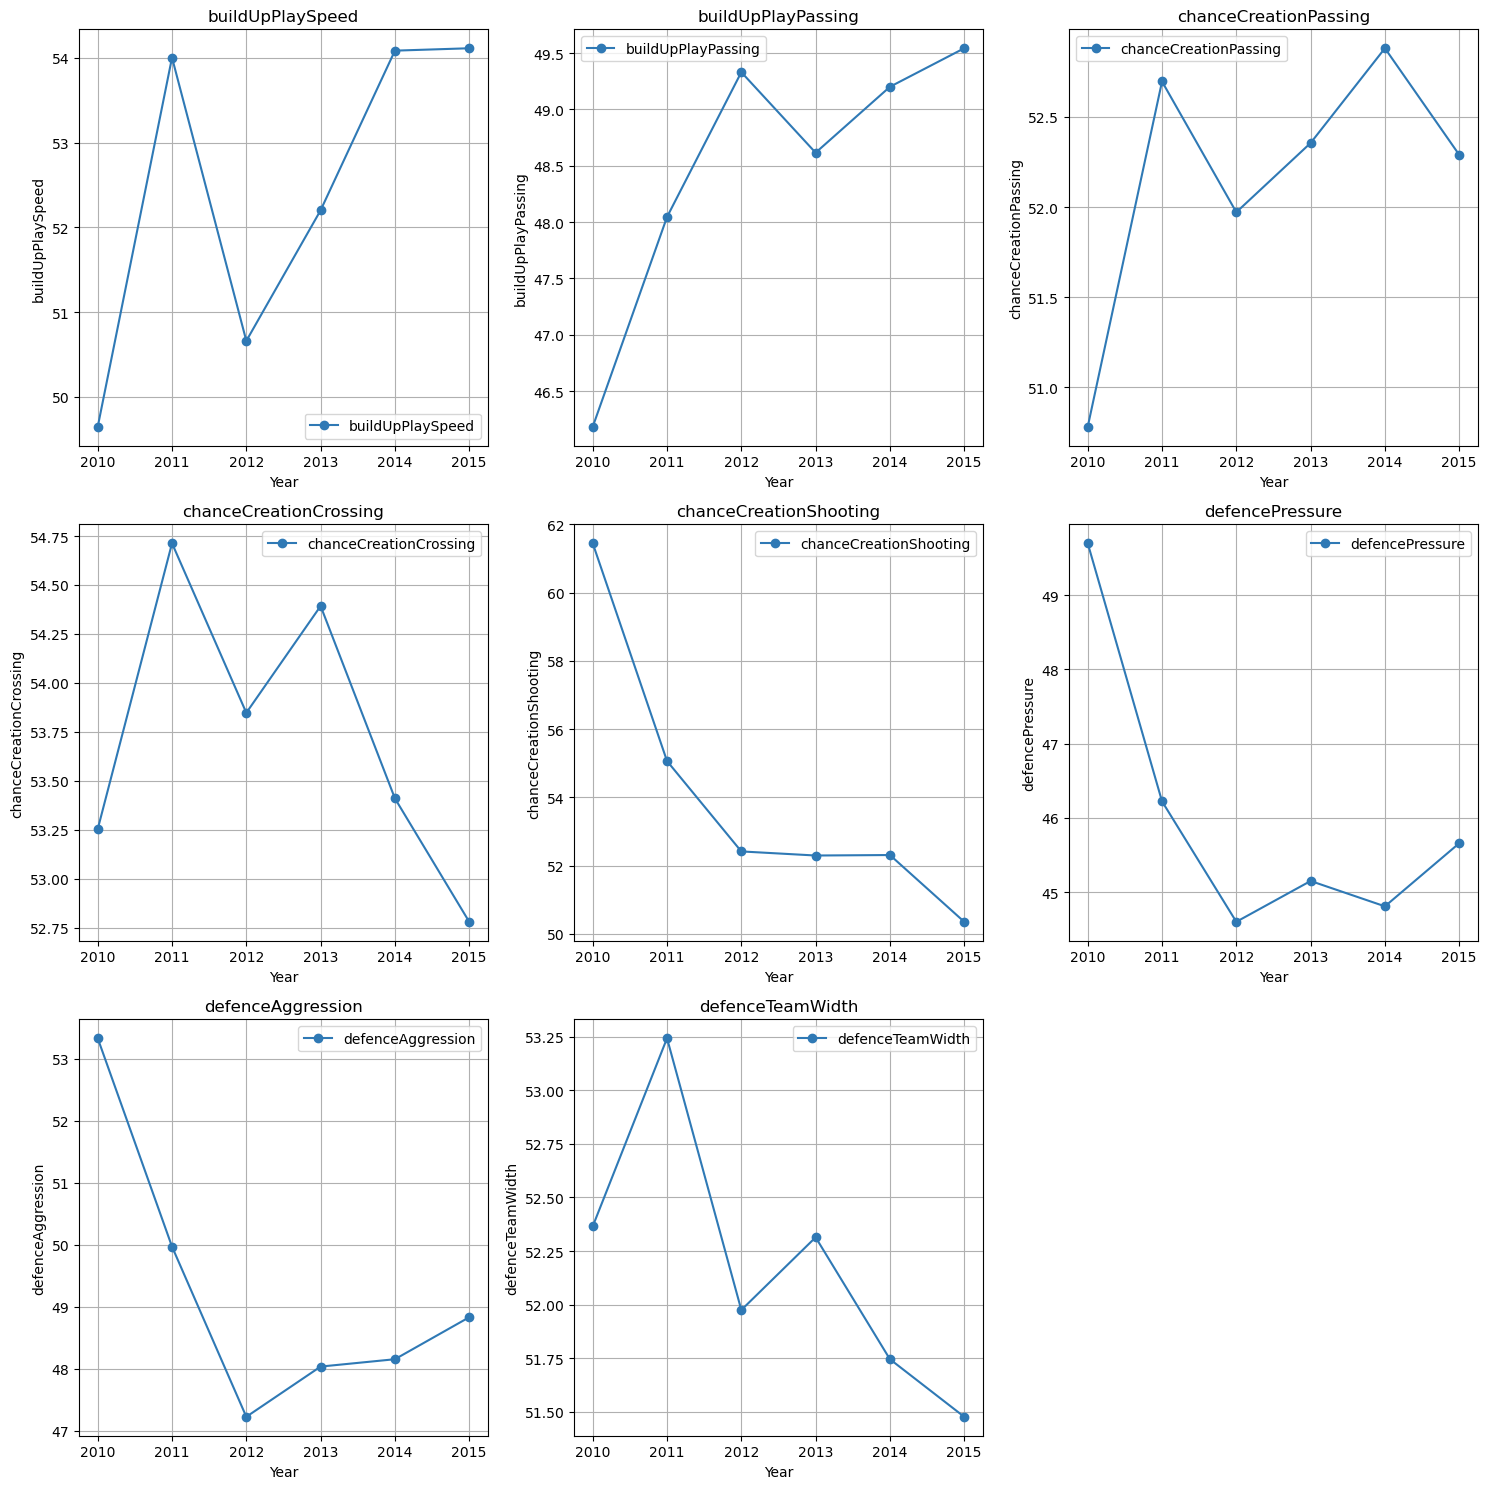

<IPython.core.display.Javascript object>

In [192]:
# Sample data
data = grouped_by_year.iloc[:, 3:]

df = pd.DataFrame(data)

n_cols = 3  # Number of columns in the grid
n_rows = -(-len(df.columns) // n_cols)  # This formula ensures you always round up

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten the axes array, in case there's more than one row
flat_axes = axes.flatten()

for i, column in enumerate(df.columns):
    ax = flat_axes[i]
    ax.plot(df.index, df[column], marker="o", label=column)
    ax.set_title(column)
    ax.set_xlabel("Year")
    ax.set_ylabel(column)
    ax.legend()
    ax.grid(True)

# If the number of features is not a multiple of n_cols, some axes will be left over.
# We need to hide them.
for i in range(len(df.columns), n_cols * n_rows):
    flat_axes[i].axis("off")

plt.tight_layout()
plt.show()

- These cannot be evaluated in isolation, each team for each match might have different strategy, or combination of these. 

Ideas:
- Possibly looking at differences or patterns of these features bewteen winning and loosing teams, would there be any predictive combinations for both teams that would more likely than not result in predicted outcome?
- Possible per team winning streak change in these features as a new feature, that could indicate pattern of team, dynamics when team is on winning streak, once this pattern would be recognized again during games, this could indicate start of the winning streak. 

In [193]:
# Looking at object dtypes in team_attributes, the ordinal values
team_attributes_objects = team_attributes.iloc[:, 4:].select_dtypes(include=["object"])

<IPython.core.display.Javascript object>

In [194]:
# Looking at number of different values per feature
team_attributes_objects.nunique()

buildUpPlaySpeedClass             3
buildUpPlayDribblingClass         3
buildUpPlayPassingClass           3
buildUpPlayPositioningClass       2
chanceCreationPassingClass        3
chanceCreationCrossingClass       3
chanceCreationShootingClass       3
chanceCreationPositioningClass    2
defencePressureClass              3
defenceAggressionClass            3
defenceTeamWidthClass             3
defenceDefenderLineClass          2
dtype: int64

<IPython.core.display.Javascript object>

In [195]:
# Counting number of times given ordinal value of a feature shows up
for column in team_attributes_objects.columns:
    print(team_attributes_objects[f"{column}"].value_counts())

Balanced    1184
Fast         172
Slow         102
Name: buildUpPlaySpeedClass, dtype: int64
Little    1004
Normal     433
Lots        21
Name: buildUpPlayDribblingClass, dtype: int64
Mixed    1236
Short     128
Long       94
Name: buildUpPlayPassingClass, dtype: int64
Organised    1386
Free Form      72
Name: buildUpPlayPositioningClass, dtype: int64
Normal    1231
Risky      171
Safe        56
Name: chanceCreationPassingClass, dtype: int64
Normal    1195
Lots       211
Little      52
Name: chanceCreationCrossingClass, dtype: int64
Normal    1224
Lots       197
Little      37
Name: chanceCreationShootingClass, dtype: int64
Organised    1309
Free Form     149
Name: chanceCreationPositioningClass, dtype: int64
Medium    1243
Deep       154
High        61
Name: defencePressureClass, dtype: int64
Press      1274
Double       99
Contain      85
Name: defenceAggressionClass, dtype: int64
Normal    1286
Wide       111
Narrow      61
Name: defenceTeamWidthClass, dtype: int64
Cover           1

<IPython.core.display.Javascript object>

In [196]:
# Mapping for ordinal values
ordinal_mappings = {
    'buildUpPlaySpeedClass': {
        'Slow': 1,
        'Balanced': 2,
        'Fast': 3
    },
    'buildUpPlayDribblingClass': {
        'Little': 1,
        'Normal': 2,
        'Lots': 3
    },
    'buildUpPlayPassingClass': {
        'Long': 1,
        'Mixed': 2,
        'Short': 3
    },
    'buildUpPlayPositioningClass': {
        'Free Form': 1,
        'Organised': 2
    },
    'chanceCreationPassingClass': {
        'Safe': 1,
        'Normal': 2,
        'Risky': 3
    },
    'chanceCreationCrossingClass': {
        'Little': 1,
        'Normal': 2,
        'Lots': 3
    },
    'chanceCreationShootingClass': {
        'Little': 1,
        'Normal': 2,
        'Lots': 3
    },
    'chanceCreationPositioningClass': {
        'Free Form': 1,
        'Organised': 2
    },
    'defencePressureClass': {
        'High': 1,
        'Medium': 2,
        'Deep': 3
    },
    'defenceAggressionClass': {
        'Contain': 1,
        'Press': 2,
        'Double': 3
    },
    'defenceTeamWidthClass': {
        'Narrow': 1,
        'Normal': 2,
        'Wide': 3
    },
    'defenceDefenderLineClass': {
        'Offside Trap': 1,
        'Cover': 2
    }
}

# Applying the encoding to the DataFrame
for column, mapping in ordinal_mappings.items():
    team_attributes[column] = team_attributes[column].map(mapping)


<IPython.core.display.Javascript object>

In [197]:
# No object features
team_attributes.select_dtypes(include=["object"])

""
0
1
2
3
4
...
1453
1454
1455
1456


<IPython.core.display.Javascript object>

#### Team Attributes VIF

In [198]:
selected_columns = [
    "buildUpPlaySpeed",
    "buildUpPlaySpeedClass",
    "buildUpPlayDribblingClass",
    "buildUpPlayPassing",
    "buildUpPlayPassingClass",
    "buildUpPlayPositioningClass",
    "chanceCreationPassing",
    "chanceCreationPassingClass",
    "chanceCreationCrossing",
    "chanceCreationCrossingClass",
    "chanceCreationShooting",
    "chanceCreationShootingClass",
    "chanceCreationPositioningClass",
    "defencePressure",
    "defencePressureClass",
    "defenceAggression",
    "defenceAggressionClass",
    "defenceTeamWidth",
    "defenceTeamWidthClass",
    "defenceDefenderLineClass",
]

subset_team_attributes = team_attributes[selected_columns]

# Normalizing data
scaler = StandardScaler()
team_attributes_normalized = pd.DataFrame(
    scaler.fit_transform(subset_team_attributes), columns=subset_team_attributes.columns
)

df_with_const = pd.concat(
    [
        pd.Series(1, index=team_attributes_normalized.index, name="const"),
        team_attributes_normalized,
    ],
    axis=1,
)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = df_with_const.columns
vif["VIF Factor"] = [
    variance_inflation_factor(df_with_const.values, i)
    for i in range(df_with_const.shape[1])
]

vif = vif[vif["Feature"] != "const"]
vif

,Feature,VIF Factor
1,buildUpPlaySpeed,2.428078
2,buildUpPlaySpeedClass,2.293995
3,buildUpPlayDribblingClass,1.066789
4,buildUpPlayPassing,2.255419
5,buildUpPlayPassingClass,2.297039
6,buildUpPlayPositioningClass,1.206112
7,chanceCreationPassing,2.235419
8,chanceCreationPassingClass,2.133040
9,chanceCreationCrossing,2.135853
10,chanceCreationCrossingClass,2.151425


<IPython.core.display.Javascript object>

- Low VIF values, low risk of multicolinearity

In [199]:
team_attributes.columns.values

array(['id', 'team_fifa_api_id', 'team_api_id', 'date',
       'buildUpPlaySpeed', 'buildUpPlaySpeedClass',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression',
       'defenceAggressionClass', 'defenceTeamWidth',
       'defenceTeamWidthClass', 'defenceDefenderLineClass'], dtype=object)

<IPython.core.display.Javascript object>

In [200]:
match_2_dropped_10_vif.columns.values

array(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_X1',
       'home_player_X2', 'home_player_X3', 'home_player_X4',
       'away_player_X1', 'away_player_X2', 'away_player_X3',
       'away_player_X4', 'home_player_Y1', 'home_player_Y2',
       'home_player_Y3', 'home_player_Y4', 'home_player_Y6',
       'home_player_Y7', 'home_player_Y8', 'away_player_Y1',
       'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
       'away_player_Y6', 'away_player_Y7', 'away_player_Y8',
       'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
       'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
       'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9'

<IPython.core.display.Javascript object>

- I've tried merging mactch data and team attributes based on period of match and attributes. So, making sure period match. But I didnt manage to pull it off.
- I will result to simpler aggregation mean for team attributes per team_api_id

#### Aggregating team attributes per team_api_id

In [201]:
team_attributes_agg = team_attributes.groupby("team_api_id").mean().reset_index()

<IPython.core.display.Javascript object>

In [202]:
team_attributes_agg.drop(columns=["id", "team_fifa_api_id"], inplace=True)

<IPython.core.display.Javascript object>

In [203]:
team_attributes_agg.shape

(288, 21)

<IPython.core.display.Javascript object>

- Here we can see even less team_api_ids then before. 11 teams less. 

In [204]:
# Team attributes
team_attributes_agg.columns.values

array(['team_api_id', 'buildUpPlaySpeed', 'buildUpPlaySpeedClass',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression',
       'defenceAggressionClass', 'defenceTeamWidth',
       'defenceTeamWidthClass', 'defenceDefenderLineClass'], dtype=object)

<IPython.core.display.Javascript object>

In [205]:
# Player attributes aggregated
player_attributes_merged_agg_final_vif_dropped.columns.values

array(['index', 'team_api_id', 'preferred_foot', 'attacking_work_rate',
       'defensive_work_rate', 'crossing', 'finishing', 'heading_accuracy',
       'free_kick_accuracy', 'acceleration', 'agility', 'balance',
       'shot_power', 'jumping', 'stamina', 'strength', 'aggression',
       'interceptions', 'penalties', 'gk_kicking', 'bmi',
       'h_win_rate_total', 'a_win_rate_total', 'HAWD', 'HALD',
       'interaction_win', 'interaction_loss', 'interaction_draw'],
      dtype=object)

<IPython.core.display.Javascript object>

#### Merging team attributes aggregate and player+winrate aggregate

In [206]:
# Merging two dataframes, team attributes aggregate, and previously built team and winrate dataframe
merged_WRPATA = pd.merge(
    team_attributes_agg,
    player_attributes_merged_agg_final_vif_dropped,
    on="team_api_id",
    how="inner",
)

<IPython.core.display.Javascript object>

In [207]:
merged_WRPATA.shape

(286, 48)

<IPython.core.display.Javascript object>

- We ended up with 286 teams and 47 features, VIF tested

In [208]:
# Vif
scaler = StandardScaler()
merged_WRPATA_normalized = pd.DataFrame(
    scaler.fit_transform(merged_WRPATA),
    columns=merged_WRPATA.columns
)

df_with_const = pd.concat([
    pd.Series(1, index=merged_WRPATA_normalized.index, name='const'),
    merged_WRPATA_normalized
], axis=1)

vif = pd.DataFrame()
vif['Feature'] = df_with_const.columns
vif['VIF Factor'] = [
    variance_inflation_factor(df_with_const.values, i)
    for i in range(df_with_const.shape[1])
]


vif = vif[vif['Feature'] != 'const']
vif


,Feature,VIF Factor
1,team_api_id,1.394671
2,buildUpPlaySpeed,3.257117
3,buildUpPlaySpeedClass,2.854949
4,buildUpPlayDribblingClass,1.591670
5,buildUpPlayPassing,3.287827
6,buildUpPlayPassingClass,3.331149
7,buildUpPlayPositioningClass,2.126556
8,chanceCreationPassing,2.973606
9,chanceCreationPassingClass,2.699854
10,chanceCreationCrossing,2.992494


<IPython.core.display.Javascript object>

In [209]:
vif[vif["VIF Factor"] > 10]

,Feature,VIF Factor
42,h_win_rate_total,10.361769


<IPython.core.display.Javascript object>

- only one feature with VIF > 10

In [210]:
# Looking at correlation in merged data
merged_WRPATA_corr = merged_WRPATA.corr()

<IPython.core.display.Javascript object>

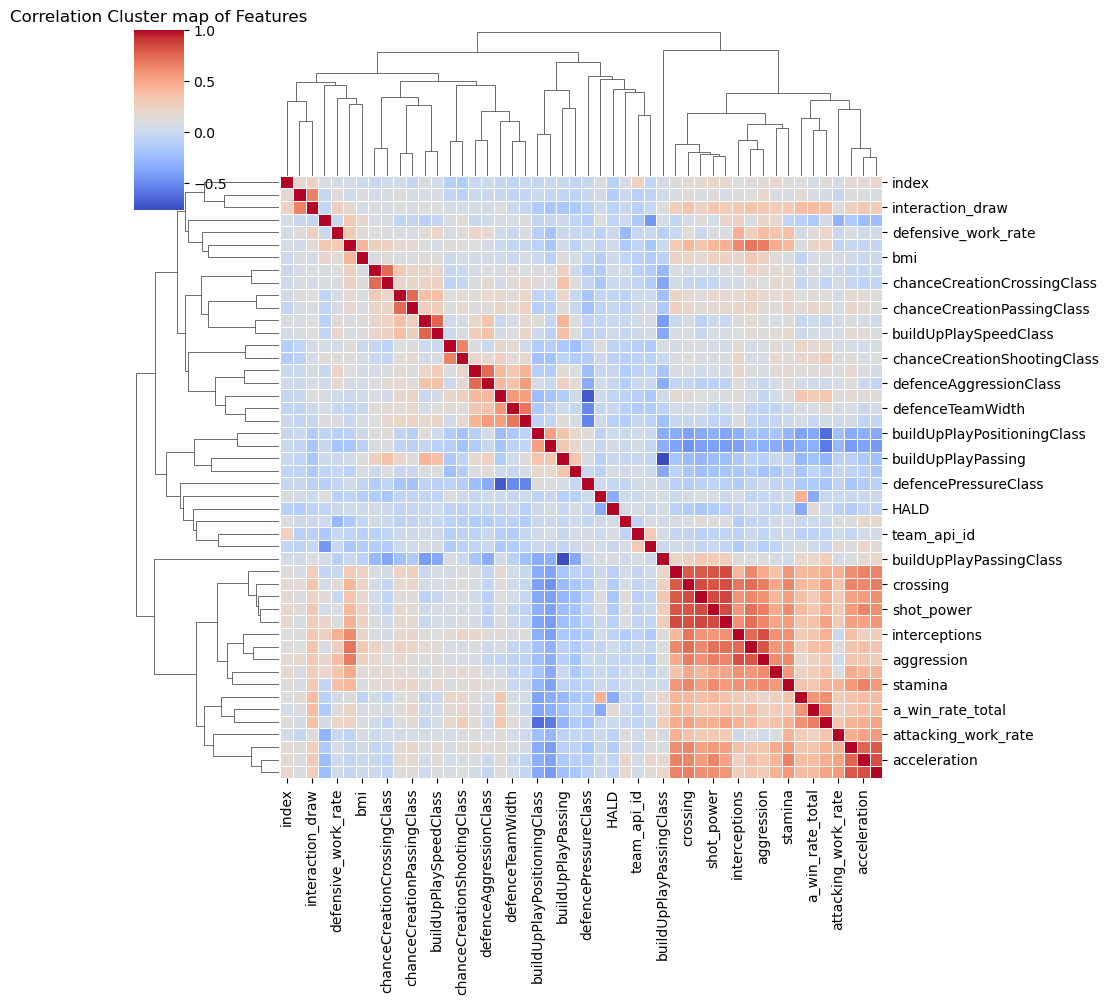

<IPython.core.display.Javascript object>

In [211]:
sns.clustermap(merged_WRPATA.corr(), cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Cluster map of Features")
plt.show()

- We can see some goruping of correlated data in lower right corner

- and few features in left lowe corner

#### Filtering highly correlated features

In [212]:
filtered_corr = merged_WRPATA_corr[
    (merged_WRPATA_corr.abs() > 0.8) & (merged_WRPATA_corr.abs() != 1)
]

# Use stack to get the pairs and their correlation values
stacked_corr = filtered_corr.stack()

# Convert the stacked Series to a DataFrame
df_corr_pairs = stacked_corr.reset_index()
df_corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]

# Convert each pair to a tuple and sort them, then convert back to a list
df_corr_pairs["Pair"] = (
    df_corr_pairs[["Feature 1", "Feature 2"]].apply(sorted, axis=1).apply(tuple)
)

# Drop duplicate pairs
df_corr_pairs = df_corr_pairs.drop_duplicates(subset="Pair").drop("Pair", axis=1)

df_corr_pairs

,Feature 1,Feature 2,Correlation
0,crossing,finishing,0.800029
1,crossing,free_kick_accuracy,0.842474
2,crossing,shot_power,0.820299
3,crossing,penalties,0.835181
5,finishing,shot_power,0.811547
6,finishing,penalties,0.844698
7,heading_accuracy,aggression,0.812212
9,free_kick_accuracy,shot_power,0.853274
10,free_kick_accuracy,penalties,0.858955
11,acceleration,agility,0.828068


<IPython.core.display.Javascript object>

In [213]:
df_corr_pairs["Feature 2"].value_counts()

penalties             4
shot_power            3
finishing             1
free_kick_accuracy    1
aggression            1
agility               1
balance               1
interceptions         1
Name: Feature 2, dtype: int64

<IPython.core.display.Javascript object>

In [214]:
df_corr_pairs["Feature 1"].value_counts()

crossing              4
finishing             2
free_kick_accuracy    2
heading_accuracy      1
acceleration          1
agility               1
shot_power            1
aggression            1
Name: Feature 1, dtype: int64

<IPython.core.display.Javascript object>

- Based on this I will remove crossing and penalties, since they show up most often. 

In [215]:
merged_WRPATA.drop(["crossing", "penalties"], axis=1, inplace=True)

# Normalizing data
scaler = StandardScaler()
merged_WRPATA_normalized = pd.DataFrame(
    scaler.fit_transform(merged_WRPATA), columns=merged_WRPATA.columns
)

# Add a constant column
df_with_const = pd.concat(
    [
        pd.Series(1, index=merged_WRPATA_normalized.index, name="const"),
        merged_WRPATA_normalized,
    ],
    axis=1,
)

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Feature"] = df_with_const.columns
vif["VIF Factor"] = [
    variance_inflation_factor(df_with_const.values, i)
    for i in range(df_with_const.shape[1])
]

# Drop the intercept term
vif = vif[vif["Feature"] != "const"]
vif

,Feature,VIF Factor
1,team_api_id,1.391420
2,buildUpPlaySpeed,3.183810
3,buildUpPlaySpeedClass,2.835407
4,buildUpPlayDribblingClass,1.589062
5,buildUpPlayPassing,3.238250
6,buildUpPlayPassingClass,3.305941
7,buildUpPlayPositioningClass,2.108181
8,chanceCreationPassing,2.966729
9,chanceCreationPassingClass,2.699282
10,chanceCreationCrossing,2.958018


<IPython.core.display.Javascript object>

In [216]:
vif[vif["VIF Factor"] > 10]

,Feature,VIF Factor
40,h_win_rate_total,10.354617


<IPython.core.display.Javascript object>

#### Final merged data

In [217]:
# Deleting the high VIF column
merged_WRPATA.drop("h_win_rate_total", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [218]:
merged_WRPATA_saved = merged_WRPATA

<IPython.core.display.Javascript object>

# Building the final combined model

In [219]:
match_2_dropped_10_vif.columns.values

array(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_X1',
       'home_player_X2', 'home_player_X3', 'home_player_X4',
       'away_player_X1', 'away_player_X2', 'away_player_X3',
       'away_player_X4', 'home_player_Y1', 'home_player_Y2',
       'home_player_Y3', 'home_player_Y4', 'home_player_Y6',
       'home_player_Y7', 'home_player_Y8', 'away_player_Y1',
       'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
       'away_player_Y6', 'away_player_Y7', 'away_player_Y8',
       'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
       'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
       'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9'

<IPython.core.display.Javascript object>

In [220]:
merged_WRPATA.columns.values

array(['team_api_id', 'buildUpPlaySpeed', 'buildUpPlaySpeedClass',
       'buildUpPlayDribblingClass', 'buildUpPlayPassing',
       'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
       'chanceCreationPassing', 'chanceCreationPassingClass',
       'chanceCreationCrossing', 'chanceCreationCrossingClass',
       'chanceCreationShooting', 'chanceCreationShootingClass',
       'chanceCreationPositioningClass', 'defencePressure',
       'defencePressureClass', 'defenceAggression',
       'defenceAggressionClass', 'defenceTeamWidth',
       'defenceTeamWidthClass', 'defenceDefenderLineClass', 'index',
       'preferred_foot', 'attacking_work_rate', 'defensive_work_rate',
       'finishing', 'heading_accuracy', 'free_kick_accuracy',
       'acceleration', 'agility', 'balance', 'shot_power', 'jumping',
       'stamina', 'strength', 'aggression', 'interceptions', 'gk_kicking',
       'bmi', 'a_win_rate_total', 'HAWD', 'HALD', 'interaction_win',
       'interaction_loss', 'interaction

<IPython.core.display.Javascript object>

In [221]:
# Merge with merged_WRPATA for home team
merged_data = pd.merge(
    match_2_dropped_10_vif,
    merged_WRPATA,
    left_on="home_team_api_id",
    right_on="team_api_id",
    how="left",
)

# Renaming columns to indicate they're attributes for the home team
for col in merged_WRPATA.columns:
    if col != "team_api_id":
        merged_data.rename(columns={col: "home_" + col}, inplace=True)

merged_data.drop("team_api_id", axis=1, inplace=True)

# Merge with merged_WRPATA for away team
merged_data = pd.merge(
    merged_data,
    merged_WRPATA,
    left_on="away_team_api_id",
    right_on="team_api_id",
    how="left",
    suffixes=("", "_away"),
)

for col in merged_WRPATA.columns:
    if col != "team_api_id":
        # Rename only the columns without suffix, as they're attributes for the away team
        merged_data.rename(columns={col: "away_" + col}, inplace=True)

merged_data.drop("team_api_id", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [222]:
merged_data.shape

(21361, 156)

<IPython.core.display.Javascript object>

#### Correlation filtering

In [223]:
merged_data_corr = merged_data.corr()

<IPython.core.display.Javascript object>

In [224]:
filtered_corr = merged_data_corr[
    (merged_data_corr.abs() > 0.8) & (merged_data_corr.abs() != 1)
]

# Use stack to get the pairs and their correlation values
stacked_corr = filtered_corr.stack()

# Convert the stacked Series to a DataFrame
df_corr_pairs = stacked_corr.reset_index()
df_corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]

# Convert each pair to a tuple and sort them, then convert back to a list
df_corr_pairs["Pair"] = (
    df_corr_pairs[["Feature 1", "Feature 2"]].apply(sorted, axis=1).apply(tuple)
)

# Drop duplicate pairs
df_corr_pairs = df_corr_pairs.drop_duplicates(subset="Pair").drop("Pair", axis=1)

df_corr_pairs

,Feature 1,Feature 2,Correlation
0,id,country_id,0.994907
1,id,league_id,0.994907
4,season,match_api_id,0.994157
5,season,year,0.975178
7,match_api_id,year,0.972042
10,home_finishing,home_free_kick_accuracy,0.817012
11,home_finishing,home_shot_power,0.825086
12,home_heading_accuracy,home_aggression,0.830085
13,home_heading_accuracy,home_interceptions,0.814827
15,home_free_kick_accuracy,home_shot_power,0.883121


<IPython.core.display.Javascript object>

In [225]:
merged_data.columns.values

array(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal', 'away_team_goal', 'home_player_X1',
       'home_player_X2', 'home_player_X3', 'home_player_X4',
       'away_player_X1', 'away_player_X2', 'away_player_X3',
       'away_player_X4', 'home_player_Y1', 'home_player_Y2',
       'home_player_Y3', 'home_player_Y4', 'home_player_Y6',
       'home_player_Y7', 'home_player_Y8', 'away_player_Y1',
       'away_player_Y2', 'away_player_Y3', 'away_player_Y4',
       'away_player_Y6', 'away_player_Y7', 'away_player_Y8',
       'home_player_1', 'home_player_2', 'home_player_3', 'home_player_4',
       'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8',
       'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9'

<IPython.core.display.Javascript object>

In [226]:
merged_data_b = merged_data

<IPython.core.display.Javascript object>

In [227]:
# removed missing values
merged_data = merged_data.dropna()
merged_data_for_vif = merged_data

<IPython.core.display.Javascript object>

#### Merged data VIF analysis

In [228]:
merged_data_for_vif.drop(['id','league_id','country_id','season','date','match_api_id'], axis=1, inplace=True)

# 1. Normalize merged_data_for_vif
scaler = StandardScaler()
merged_data_for_vif_normalized = pd.DataFrame(
    scaler.fit_transform(merged_data_for_vif.select_dtypes(include=[np.number])),
    columns=merged_data_for_vif.select_dtypes(include=[np.number]).columns
)

# 2. Add a constant column
df_with_const = pd.concat([
    pd.Series(1, index=merged_data_for_vif_normalized.index, name='const'),
    merged_data_for_vif_normalized
], axis=1)

# 3. Calculate VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = df_with_const.columns
vif['VIF Factor'] = [
    variance_inflation_factor(df_with_const.values, i)
    for i in range(df_with_const.shape[1])
]

# Drop the intercept term
vif = vif[vif['Feature'] != 'const']
vif


/tmp/ipykernel_75461/2071004952.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_for_vif.drop(['id','league_id','country_id','season','date','match_api_id'], axis=1, inplace=True)
/home/martin/anaconda3/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,Feature,VIF Factor
1,stage,1.657353
2,home_team_api_id,1.358525
3,away_team_api_id,1.276618
4,home_team_goal,2.559092
5,away_team_goal,2.522906
...,...,...
146,away_HAWD,1.691655
147,away_HALD,1.314162
148,away_interaction_win,7.088707
149,away_interaction_loss,2.154509


<IPython.core.display.Javascript object>

In [229]:
vif_to_rm_10 = vif[vif["VIF Factor"] > 10]["Feature"].to_list()

<IPython.core.display.Javascript object>

In [230]:
vif_to_rm_5 = vif[vif["VIF Factor"] > 5]["Feature"].to_list()

<IPython.core.display.Javascript object>

In [231]:
merged_data_10_vif = merged_data.drop(vif_to_rm_10, axis=1)

<IPython.core.display.Javascript object>

In [232]:
merged_data_5_vif = merged_data.drop(vif_to_rm_5, axis=1)

<IPython.core.display.Javascript object>

In [233]:
merged_data_10_vif.drop(["home_team_goal", "away_team_goal"], axis=1, inplace=True)

<IPython.core.display.Javascript object>

### Models 

In [234]:
merged_data_10_vif_b = merged_data_10_vif

<IPython.core.display.Javascript object>

#### Logistic regression - home team outcome

In [235]:
df = merged_data_10_vif.drop('winner',axis=1)

# Define dependent and independent variables
y = df['home_team_outcome']
X = df.drop(columns=['home_team_outcome'])  # Drop the target column to use all other features

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, multi_class='multinomial')  # You can also try 'ovr' for one-vs-rest
log_reg.fit(X_train, y_train)

# Making Predictions
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))


Accuracy: 0.5267247468801507
              precision    recall  f1-score   support

          -1       0.49      0.45      0.47      1212
           0       0.41      0.06      0.10      1104
           1       0.54      0.84      0.66      1931

    accuracy                           0.53      4247
   macro avg       0.48      0.45      0.41      4247
weighted avg       0.50      0.53      0.46      4247



<IPython.core.display.Javascript object>

The data is split into training and test sets with 80% for training and 20% for testing.
The features are standardized for better convergence of the logistic regression model.
A multinomial logistic regression model is trained on the training data.

- Model Performance:

Accuracy: The model achieved an accuracy of approximately 52.67% on the test set.
Class-wise Metrics:

----
Class -1:
Precision: 49% (Of the instances the model predicted as class -1, 49% were actually -1)
Recall: 45% (Of the actual instances of class -1, the model correctly identified 45%)
F1-score: 47% (Harmonic mean of precision and recall)

----
Class 0:
Precision: 41%
Recall: 6%
F1-score: 10%

----
Class 1:
Precision: 54%
Recall: 84%
F1-score: 66%

The model is most proficient at predicting class 1 (with a recall of 84%), meaning it's good at identifying matches where the home team wins.
The model struggles significantly with class 0 (draws) with only a 6% recall, suggesting that draws are hardest for the model to predict correctly.
The precision for class 0 (draws) is also quite low, meaning that most of the times the model predicts a draw, it's often incorrect.
The weighted average F1-score is 46%, which gives an indication of the model's overall performance when considering both precision and recall.

### Random forest model

In [236]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf_model = RandomForestClassifier(
    n_estimators=100, random_state=42
)  # you can adjust parameters as needed
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

report = classification_report(y_test, y_pred)
print(report)

Accuracy: 0.4958794443136332
              precision    recall  f1-score   support

          -1       0.45      0.43      0.44      1212
           0       0.29      0.11      0.16      1104
           1       0.55      0.76      0.64      1931

    accuracy                           0.50      4247
   macro avg       0.43      0.43      0.41      4247
weighted avg       0.45      0.50      0.46      4247



<IPython.core.display.Javascript object>

In [238]:
X = df.drop('home_team_outcome', axis=1)
y = df['home_team_outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training the random forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Making predictions and evaluating the model
y_pred = rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.4958794443136332
              precision    recall  f1-score   support

          -1       0.45      0.43      0.44      1212
           0       0.29      0.11      0.16      1104
           1       0.55      0.76      0.64      1931

    accuracy                           0.50      4247
   macro avg       0.43      0.43      0.41      4247
weighted avg       0.45      0.50      0.46      4247



<IPython.core.display.Javascript object>

In [239]:
importances = rf_model.feature_importances_
features = X.columns
feature_importances = pd.DataFrame(
    {"Feature": features, "Importance": importances}
).sort_values(by="Importance", ascending=False)
print(feature_importances)

           Feature  Importance
47           B365H    0.034147
44   away_player_9    0.017251
30   home_player_6    0.017038
34  home_player_10    0.017025
43   away_player_8    0.016959
..             ...         ...
19  away_player_Y2    0.000000
18  away_player_Y1    0.000000
13  home_player_Y3    0.000000
12  home_player_Y2    0.000000
11  home_player_Y1    0.000000

[138 rows x 2 columns]


<IPython.core.display.Javascript object>

In [240]:
df = merged_data_10_vif
# Splitting the data into train and test sets
X = df.drop(["winner"], axis=1)
y = df["winner"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Training the logistic regression model
logreg = LogisticRegression(
    max_iter=10000
)  # Increase max_iter if convergence issues arise
logreg.fit(X_train, y_train)

# Making predictions and evaluating the model
y_pred = logreg.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

accuracy_score

Accuracy: 0.43371791853072755


<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>

<IPython.core.display.Javascript object>

In [242]:
# Considering goals as categories
y_train = y_train.astype('str')
y_test = y_test.astype('str')

model_lr = LogisticRegression(max_iter=10000, random_state=42)  # Increased max_iter for convergence
model_lr.fit(X_train, y_train)

# Predictions and Evaluation
y_pred_lr = model_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy}")


Logistic Regression Accuracy: 0.4339533788556628


<IPython.core.display.Javascript object>

# What I've could have done better

- Include and parse XML data in analysis
- Explore more the tome dimension of data and teams playing patterns though time
- Use coordinates as positioning grops and analyze from that perspective
- Try to do PCA
- After model building revisit features and try to run model again until it improves potentially
- Do more feature elimination techniques than just VIF and correlation, or be more precise with these two, not just filtering based on cutoffpoints, but removing/adding features 1 by one sseing changes to optimize the results
- Had more practical, advice for either teams or betting organisations
- Better structure to the entire project with more intuitive flow
- Wrote short summaries after each significant segment of analysis
- Written down steps of my thinking process at some parts
- Utilized more of statistical iference methods when it comes to feature selection, engeneering and evaluation. 